In [548]:
%matplotlib inline

import IPython.core.debugger
dbg = IPython.core.debugger.Pdb()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import median, mean
from pprint import pprint
import sys
from glob import glob

from ipywidgets import interact, interactive, fixed, interact_manual, widgets
from IPython.display import display

CALLER = 'strelka2'
venn_field = 'caller'
#venn_left = 'strelka2'
#venn_right = 'ensemble'
venn_left = 'vardict'
venn_right = 'strelka2'
vl = venn_left
vr = venn_right
l = vl[0]
r = vr[0]

callers = ['strelka2', 'ensemble', 'vardict']
benchmark_d = {
    'mb_100v100': {
        'src_vcf': 'batch1-{c}-annotated.vcf.gz',
        'bench': 'mb',
    },
    'mb_300v50': {
        'src_vcf': 'MB_300vs50-{c}-annotated.vcf.gz',
        'bench': 'mb',
    },
    'colo_40pc_ds': {
        'src_vcf': 'COLO829_40pc_ds-{c}.vcf.gz',
        'bench': 'colo',
    },
    'colo_40pc_full': {
        'src_vcf': 'COLO829_40pc-{c}.vcf.gz',
        'bench': 'colo',
    },
    'colo_tgen': {
        'src_vcf': 'COLO_TGEN_bwa-{c}.vcf.gz',
        'bench': 'colo',
    },
    'colo_hoffman': {
        'src_vcf': 'COLO829_40pc-{c}.vcf.gz',
        'bench': 'colo',
    },
}
for n, d in benchmark_d.items():
    d['name'] = n
    d['df'] = None
    d['eval_dir'] = f'{n}/evalled'
    d['isec_dir_glob'] = f'{d["eval_dir"]}/eval/*{{c}}*_bcftools_isec'
MinEVS = 6

In [542]:
from ngs_utils.file_utils import add_suffix, file_exists, splitext_plus, intermediate_fname
from os.path import basename, splitext, dirname

def _load(n):
    d = benchmark_d[n]
    print(f'Benchmarking VCFs for {n}')
    vcfs = []
    eval_dir = f'{n}/evalled'
    vcfprep_dir = f'{n}/vcfprep'
    !mkdir -p {vcfprep_dir}
    for c in callers:
        vcf = join(n, d['src_vcf'].format(c=c))
        if file_exists(vcf):
            vcf_pass = intermediate_fname(vcfprep_dir, vcf, 'pass')
            if not file_exists(vcf_pass):
                cmd = f'bcftools view -f.,PASS {vcf} -Oz -o {vcf_pass} && tabix -p vcf {vcf_pass}'
                print(cmd)
                !{cmd}   
            vcf_prep = intermediate_fname(vcfprep_dir, vcf, 'prep')
            if not file_exists(vcf_prep):
                cmd = f'pcgr_prep {vcf_pass} | bcftools view -f.,PASS -Oz -o {vcf_prep} && tabix -p vcf {vcf_prep}'
                print(cmd)
                !{cmd}   
            vcf_pon = intermediate_fname(vcfprep_dir, vcf, 'pon')
            if not file_exists(vcf_pon):
                cmd = f'pon_anno {vcf_prep} -o {vcf_pon} && tabix -p vcf {vcf_pon}'
                print(cmd)
                !{cmd}   
            vcfs.append(vcf_pon)

#             vcf_basename = splitext_plus(basename(vcf_pon))[0]
#             d['isec_dir'] = f'{eval_dir}/eval/{vcf_basename}_bcftools_isec'.replace(c, '{c}')

    if vcfs:
        !eval_vcf {d['bench']} {' '.join(vcfs)} -o {eval_dir} --anno-tricky

#for n, d in benchmark_d.items(): 
#_load('colo_hoffman')
_load('mb_100v100')
_load('colo_40pc_ds')

Benchmarking VCFs for mb_100v100
set -o pipefail; snakemake --snakefile /Users/vsaveliev/git/umccr/vcf_stuff/vcf_stuff/eval_vcf/vcf.smk --printshellcmds --directory mb_100v100/evalled --configfile /var/folders/27/5lz7p3r95hx6kt9dd_r377jm8wpgwy/T/tmpxqys9wu_ --jobs 1 
Building DAG of jobs...
Nothing to be done.
Complete log: /Users/vsaveliev/git/umccr/vcf_stuff/vcf_stuff/filtering/mb_100v100/evalled/.snakemake/log/2018-10-18T150024.675869.snakemake.log
Results are in "mb_100v100/evalled" folder. E.g. final report saved to "mb_100v100/evalled/report.tsv"
Benchmarking VCFs for colo_40pc_ds
set -o pipefail; snakemake --snakefile /Users/vsaveliev/git/umccr/vcf_stuff/vcf_stuff/eval_vcf/vcf.smk --printshellcmds --directory colo_40pc_ds/evalled --configfile /var/folders/27/5lz7p3r95hx6kt9dd_r377jm8wpgwy/T/tmpeh6__mm1 --jobs 1 
Building DAG of jobs...
Nothing to be done.
Complete log: /Users/vsaveliev/git/umccr/vcf_stuff/vcf_stuff/filtering/colo_40pc_ds/evalled/.snakemake/log/2018-10-18T150027.

In [584]:
# Parsing VCF for Strelka2, VarDict, and Mutect2 paired somatic calls, loading into DataFrame.
# Earlier we intersected VCFs against the truth set with 
# https://github.com/umccr/vcf_stuff/#variant-calling-evaluataion, so here we have 3 sets of VCFs 
# for each caller: 
#  - `0000.vcf` (false positives), 
#  - `0001.vcf` (false negatives), 
#  - `0002.vcf` (true positives).

from cyvcf2 import VCF
from collections import defaultdict
from ngs_utils.vcf_utils import get_tumor_sample_id
from ngs_utils.file_utils import add_suffix
import os

from os.path import join
from collections import Counter

def int_to_chrom(val):
    if val == 23: return 'X'
    if val == 24: return 'Y'
    if val == 25: return 'MT'
    if val == 0: return None
    return str(val)
    
def chrom_to_int(chrom):
    if chrom == 'X': return 23
    if chrom == 'Y': return 24
    if chrom == 'MT': return 25
    try:
        return int(chrom)
    except:
        return 0

with open('GRCh37.fa.fai') as f:
    chrom_lens = [(l.split('\t')[0], int(l.split('\t')[1])) for l in f if l.strip()]
    chrom_lens = [(c, l) for c, l in chrom_lens if not c.startswith('GL')]
chrom_positions = [(chrom, sum(l for c, l in chrom_lens if chrom_to_int(c) < chrom_to_int(chrom))) 
                        for chrom, _ in chrom_lens] \
                   + [(None, sum(l for c, l in chrom_lens))]
    
main_sample_index = 0  # get_tumor_sample_id(mm2_vcf)

def reject_variant(rec):
    reject = False
    return reject

def rec_to_fields(rec, caller):
    fields = dict()
    for tag in ['AF', 'DP', 'MQ', 'MQ0']:
        for ph in ['TUMOR', 'NORMAL']:
            v = rec.INFO.get(f'{ph}_{tag}')
            if v is not None:
                fields[f'{ph}_{tag}'] = v

    fields[f'QUAL'] = rec.QUAL

    if caller == 'vardict':
        fields[f'NM'] = rec.format('NM')[main_sample_index][0]
        fields[f'vardict_QUAL'] = rec.format('QUAL')[main_sample_index][0]

    ann = rec.INFO.get('ANN')
    if isinstance(ann, str):  # skip decomposed fields with lost ANN
        fields['gene'] = ann.split('|')[3]

    if caller == 'strelka2':
        fields[f'SomaticEVS'] = rec.INFO.get('SomaticEVS')
        fields[f'ReadPosRankSum'] = rec.INFO.get('ReadPosRankSum')
    
    fields[f'PoN_CNT'] = rec.INFO.get('PoN_CNT', 0)
    return fields

def _get_vcfs(b, types=None):
    vcfs = defaultdict(dict)
    for c in callers:
        isec_dir = glob(b['isec_dir_glob'].format(c=c))
        if isec_dir:
            isec_dir = isec_dir[0]
            vcfs[c] = dict(
                fp=join(isec_dir, '0000.vcf'),
                fn=join(isec_dir, '0001.vcf'),
                tp=join(isec_dir, '0002.vcf'),
            )
            if types:
                for typ in ['fp', 'fn', 'tp']:
                    if typ not in types:
                        del vcfs[c][typ]
    return vcfs

def load_vcfs(bn, types=None, annotate_pon=False, silent=False):
    if not silent: print('Loading for benchmark ' + bn)
    if not silent: print('--------------------------')
    b = benchmark_d[bn]
    vcfs = _get_vcfs(b, types)    
    rows = []
    recs_by_loc = defaultdict(lambda: {c: (None, 'tn') for c in callers})
    for caller in callers:
        if not silent: print(f'Parsing VCFs for {caller}')
        for typ, vcf in vcfs[caller].items():
            print(f'  reading {vcf}')
            for rec in VCF(vcf):    
#                if rec.CHROM != '21':
#                    continue
                k = (rec.CHROM, rec.POS, rec.REF, rec.ALT[0])
                recs_by_loc[k][caller] = rec, typ

    print(f'  Analysing data, building dataframe...')
    total = 0
    passed = 0
    rows = []
    for (chrom, pos, ref, alt), d in sorted(recs_by_loc.items(), key=lambda a: a[0]):
        total += 1
        assert any(d[c] for c in callers)

        fields = dict(gene='')
        rec = None
        for caller in callers:
            c_rec, c_typ = d[caller]
            fields[f'{caller}_typ'] = c_typ
            if c_typ in ('fp', 'tp') or rec is None and c_rec is not None:
                rec = c_rec
                fields.update(rec_to_fields(rec, caller))
                 
        x = next((p for c, p in chrom_positions if str(c) == str(chrom)), None)
        if x is None: continue
        x += pos

        if reject_variant(rec):
            continue
        passed += 1

        tricky_anno = rec.INFO.get('TRICKY', '').split(',')
        tricky_anno = tuple(tricky_anno)

        row = {
            'chrom_pos': f'{rec.CHROM}:{rec.POS}',
            'label': f'{chrom}:{pos}-{ref}>{alt}', 
            'benchmark': bn,
            'is_snp': rec.is_snp,
            'tricky_anno': tricky_anno,
            'pos': pos,
            'chrom': chrom,
            'x': x,
        }
        row.update(fields)
        assert pos
        rows.append(row)

    if not silent: print(f'Done parsing {total} variants, saved {passed}')
    if not silent: print()

    df = pd.DataFrame(rows).set_index('label', drop=False)
    if types is None:
        b['df'] = df
    return df

load_vcfs('mb_100v100')
load_vcfs('mb_300v50')
load_vcfs('colo_40pc_full')
load_vcfs('colo_40pc_ds')
load_vcfs('colo_tgen')
load_vcfs('colo_hoffman')
pass

Loading for benchmark mb_100v100
--------------------------
Parsing VCFs for strelka2
  reading mb_100v100/evalled/eval/batch1-strelka2-annotated.pon_bcftools_isec/0000.vcf
  reading mb_100v100/evalled/eval/batch1-strelka2-annotated.pon_bcftools_isec/0001.vcf
  reading mb_100v100/evalled/eval/batch1-strelka2-annotated.pon_bcftools_isec/0002.vcf
Parsing VCFs for ensemble
  reading mb_100v100/evalled/eval/batch1-ensemble-annotated.pon_bcftools_isec/0000.vcf
  reading mb_100v100/evalled/eval/batch1-ensemble-annotated.pon_bcftools_isec/0001.vcf
  reading mb_100v100/evalled/eval/batch1-ensemble-annotated.pon_bcftools_isec/0002.vcf
Parsing VCFs for vardict
  reading mb_100v100/evalled/eval/batch1-vardict-annotated.pon_bcftools_isec/0000.vcf
  reading mb_100v100/evalled/eval/batch1-vardict-annotated.pon_bcftools_isec/0001.vcf
  reading mb_100v100/evalled/eval/batch1-vardict-annotated.pon_bcftools_isec/0002.vcf
  Analysing data, building dataframe...
Done parsing 106094 variants, saved 106094


In [505]:
_df = benchmark_d['mb_300v50']['df'].query(
   'caller=="ensemble" & is_snp==True & ensemble_typ=="fp"').sort_values(by=['chrom','pos'])
# _df
# print(len(_df.index.tolist()))
# for index, row in _df.iterrows():
#     print(row['label'])

In [509]:

pass

Loading for benchmark mb_300v50
--------------------------
{'src_vcf': 'mb_300v50/MB_300vs50-{c}-annotated.vcf.gz', 'bench': 'mb', 'name': 'mb_300v50', 'df': None, 'isec_dir': 'mb_300v50/evalled/eval/MB_300vs50-{c}-annotated.prep.pon_bcftools_isec'}
Parsing VCFs for strelka2
  reading mb_300v50/evalled/eval/MB_300vs50-strelka2-annotated.prep.pon_bcftools_isec/0000.vcf
  reading mb_300v50/evalled/eval/MB_300vs50-strelka2-annotated.prep.pon_bcftools_isec/0001.vcf
  reading mb_300v50/evalled/eval/MB_300vs50-strelka2-annotated.prep.pon_bcftools_isec/0002.vcf
Parsing VCFs for ensemble
  reading mb_300v50/evalled/eval/MB_300vs50-ensemble-annotated.prep.pon_bcftools_isec/0000.vcf
  reading mb_300v50/evalled/eval/MB_300vs50-ensemble-annotated.prep.pon_bcftools_isec/0001.vcf
  reading mb_300v50/evalled/eval/MB_300vs50-ensemble-annotated.prep.pon_bcftools_isec/0002.vcf
  Analysing data, building dataframe...
Done parsing 3748 variants, saved 3722

Loading for benchmark colo_40pc_full
-----------

# Venn

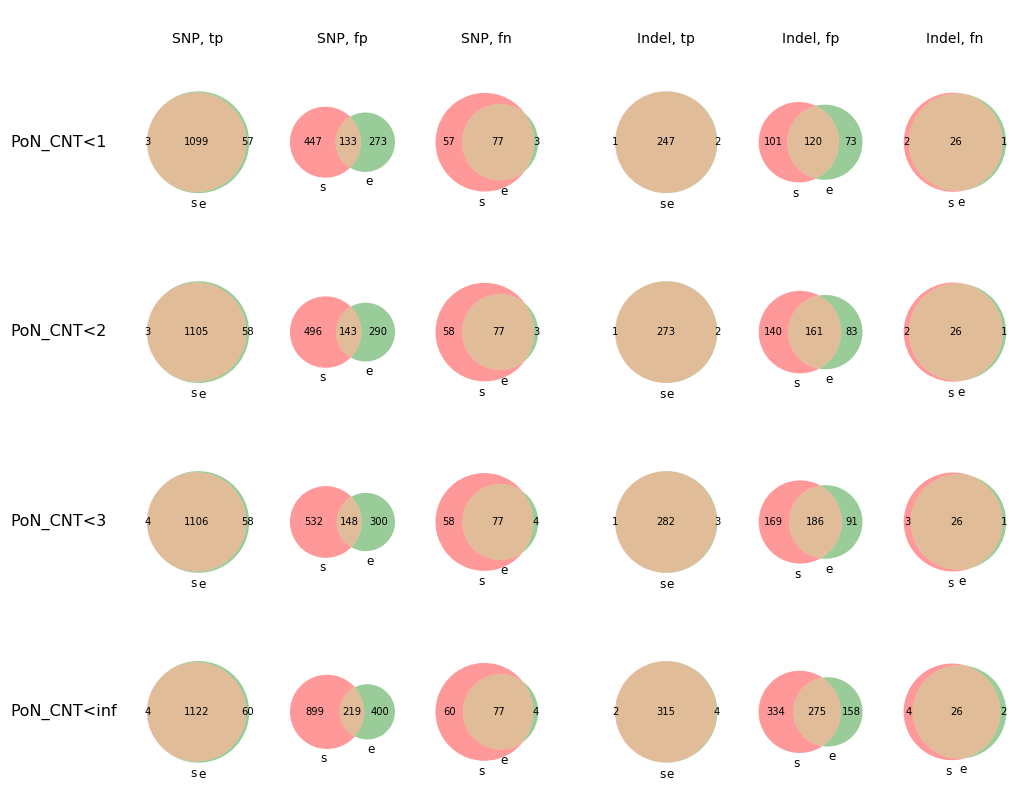

In [62]:
# Counting statistics on per-chromosome basis: unique to BWA vs. unqiue to minimap2 vs. 
# common calls. Drawing summary Venn diagrams for each caller and aligner:
# 
# mm2/bwa ensemble    tp-snp  tp-ind  fp-snp  fp-ind  fn-snp  fn-ind 
# mm2/bwa strelka2    --//--  --//--
# mm2/bwa mutect2     --//--
# mm2/bwa vardict
# v/s/m bwa  
# v/s/m mm2            

from matplotlib_venn import venn2, venn3
from matplotlib import gridspec
import itertools
import math

criteria_name = 'PoN_CNT'
rows_criterias = [1, 2, 3, math.inf]
criteria_op = '<'

def plot_venn(bn, df=None):
    b = benchmark_d[bn]
    df = df if (df is not None) else benchmark_d[bn]['df']

    validation_types = ['tp', 'fp', 'fn']
    event_types = [True, False]  # SNP, non-SNP

    rows_cnt = len(rows_criterias)
    figsize = (18, 3.6*rows_cnt)
    fig = plt.figure(figsize=figsize)
    outer = gridspec.GridSpec(1 + rows_cnt, 
                              1 + len(event_types),
                              height_ratios=[1] + [7]*rows_cnt,
                              width_ratios=[1] + [2*len(validation_types)] * len(event_types))
                              
    def left_col_label(txt, ax):
        plt.text(0, 0.5, txt,
            fontsize=16,
            horizontalalignment='left',
            verticalalignment='center')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)     
        plt.axis('off')
            
    # HEADER
    for is_snp_i, is_snp in enumerate(event_types):
        inner = gridspec.GridSpecFromSubplotSpec(1, len(validation_types), 
                                                 subplot_spec=outer[0, 1 + is_snp_i])
        lbl = 'SNP' if is_snp else 'Indel'
        for typ_i, typ in enumerate(validation_types):
            ax = plt.subplot(inner[typ_i])
            plt.text(0.5, -0.5, f'{lbl}, {typ}',
                fontsize=14,
                horizontalalignment='center',
                verticalalignment='bottom',
            )
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)     
            plt.axis('off')

    # 2-way L vs R, one raw for a criteria
    for criteria_i, criteria in enumerate(rows_criterias):
        ax = plt.subplot(outer[1 + criteria_i, 0])
        left_col_label(f'{criteria_name}{criteria_op}{criteria}' if criteria is not None else '', ax)

        for is_snp_i, is_snp in enumerate(event_types):
            inner = gridspec.GridSpecFromSubplotSpec(1, len(validation_types), 
                             subplot_spec=outer[1 + criteria_i, 1 + is_snp_i])
            lbl = 'SNP' if is_snp else 'Indel'
            for typ_i, typ in enumerate(validation_types):
#                dbg.set_trace()
                ax = plt.subplot(inner[typ_i])
                #sets = [set(df.query( & is_snp == {is_snp}').index.tolist())]          
                dff = df.query(f'is_snp == {is_snp}')
                if criteria: dff = dff.query(f'{criteria_name}{criteria_op}{criteria}')
                sets = [set(dff.query(f'{p}_typ == "{typ}"').index.tolist()) for p in [venn_left, venn_right]]    
                venn2(sets, set_labels=[l, r], ax=ax)

#     # 3-way Strelka2 vs Mutect vs VarDict, one raw for each aligner
#     clrs = [c for c in b['callers'] if c != 'ensemble']   
#     for aln_i, aln in enumerate(['bwa', 'mm2']):
#         ax = plt.subplot(outer[1 + len(b['callers']) + aln_i, 0])
#         left_col_label(aln, ax)
        
#         for is_snp_i, is_snp in enumerate(event_types):
#             inner = gridspec.GridSpecFromSubplotSpec(1, len(validation_types), 
#                              subplot_spec=outer[1 + len(b['callers']) + aln_i, 1 + is_snp_i])
#             lbl = 'SNP' if is_snp else 'Indel'
#             for typ_i, typ in enumerate(validation_types):
#                 ax = plt.subplot(inner[typ_i])
#                 sets = [set(df.query(f'{aln}_t == "{typ}" & caller == "{clr}" & is_snp == {is_snp}').index.tolist())
#                         for clr in clrs]                
#                 venn3(sets, set_labels=clrs, ax=ax)
                
plot_venn('mb_ds')
plot_venn('mb_300v50')
plot_venn('colo_40pc_ds')
plot_venn('colo_40pc_full')
plot_venn('colo_tgen')

# RoC

Plotting mb_100v100


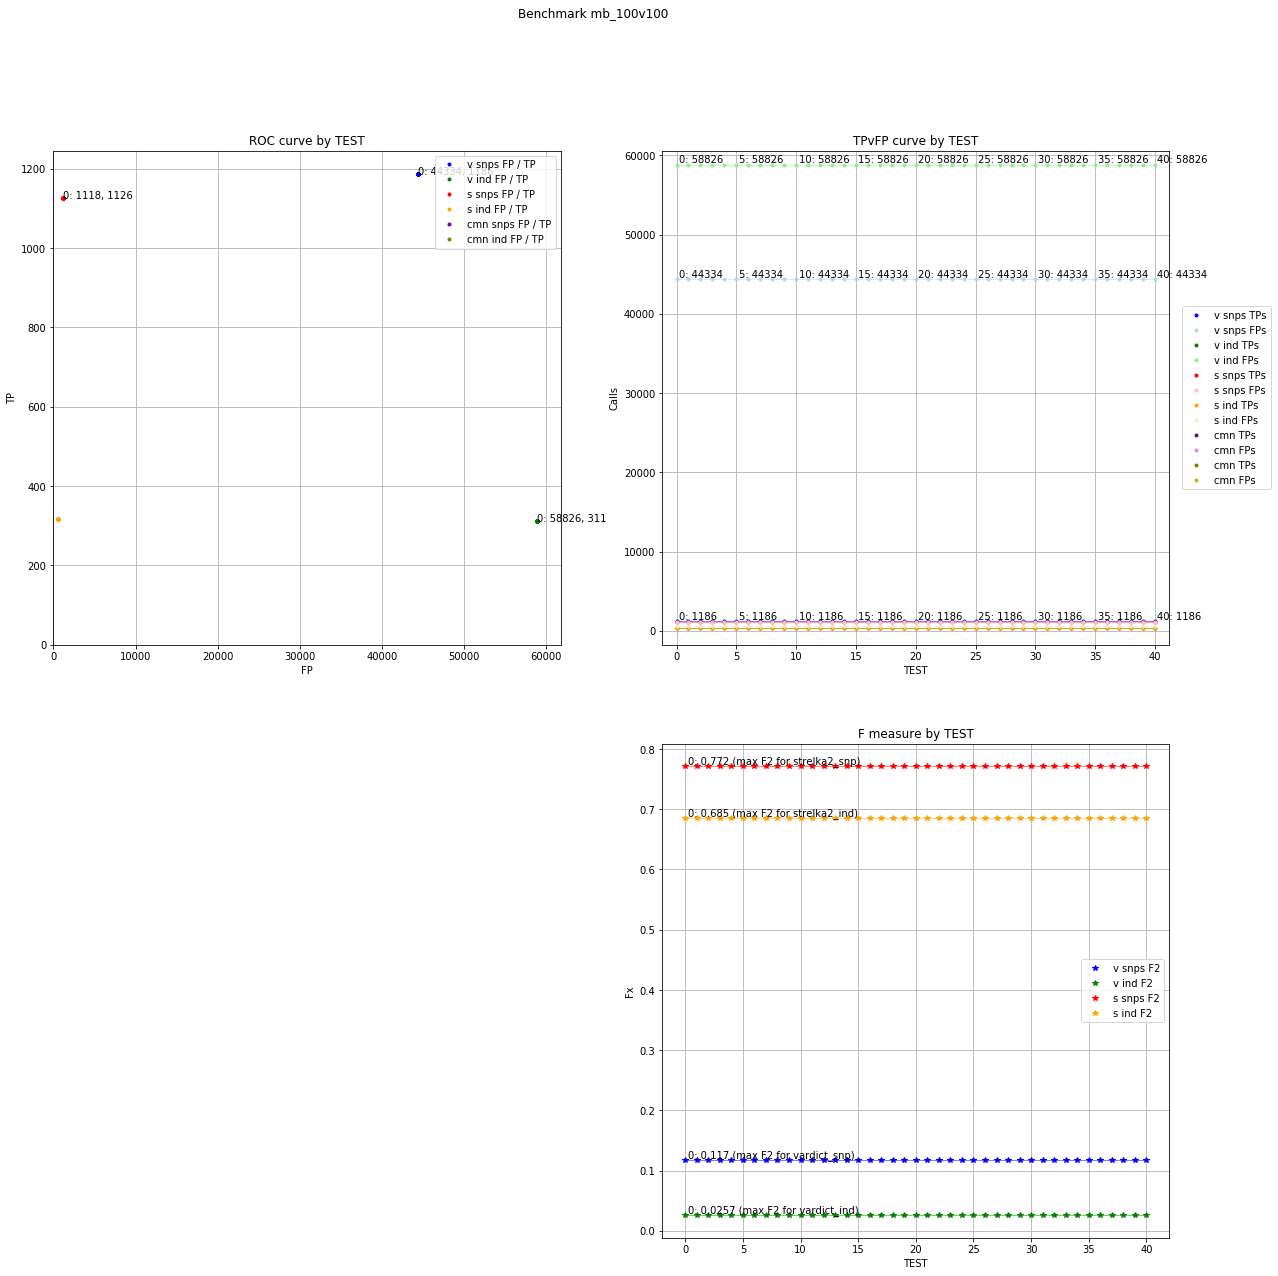

In [581]:
# Defining function for plotting ROC and TP/FP ratios curves

from matplotlib import gridspec

#F_MEASURES = {1: '.', 1.5: 'x', 2: '*'}
#F_MEASURES = {1.5: 'x', 2: '*'}
F_MEASURES = {2: '*'}

def f_measure(b, prec, recall):
    return (1 + b**2) * prec * recall / (b**2 * prec + recall) if prec + recall > 0 else 0

def plot_roc(bn, roc_field, start, end, step=1, label_step=5, show_values=True, filt_fn=None, 
             field_fn=None, df=None, skip_l=False, skip_r=False):
    b = benchmark_d[bn]
    df = df if (df is not None) else benchmark_d[bn]['df']
    assert df is not None
    
    if filt_fn:
        df = df[df.apply(filt_fn, axis=1)]
    if field_fn:
        df[f'{roc_field}'] = df.apply(field_fn, axis=1)

    print(f'Plotting {bn}')
    fig = plt.figure(figsize=(20, 20))
    grid = gridspec.GridSpec(2, 2, width_ratios=[1, 1])
    plt.suptitle(f'Benchmark {bn}')

    roc_ax = plt.subplot(grid[0], label=f'ROC {roc_field.upper()}', title=f'ROC curve by {roc_field.upper()}')
    roc_ax.set_xlabel('FP')
    roc_ax.set_ylabel('TP')
    plt.grid()

    tp_fp_ax = plt.subplot(grid[1], label=f'TPvFP {roc_field.upper()}', title=f'TPvFP curve by {roc_field}')  
    tp_fp_ax.set_xlabel(f'{roc_field}')
    tp_fp_ax.set_ylabel('Calls')
    plt.grid()

    f_measure_ax = plt.subplot(grid[3], label=f'Fx by {roc_field.upper()}', title=f'F measure by {roc_field}')
    f_measure_ax.set_xlabel(f'{roc_field}')
    f_measure_ax.set_ylabel('Fx')
    plt.grid()

    # Pre-calculation    
    max_fm_by_m_by_k = {k + is_snp: {m: (0, None) for m in F_MEASURES} for k in [vl, vr] for is_snp in ['_snp', '_ind']}
    tps_by_k, fns_by_k, fps_by_k, fms_by_k = defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)
    for sample_k in [vl, vr]:
        for is_snp in [True, False]: 
            vals = np.arange(start, end + step, step)
            for val in vals:
                val_df = df[df[f'{roc_field}'] >= val][df['is_snp'] == is_snp]

                tp = len(val_df[val_df[f'{sample_k}_typ'] == 'tp'])
                fn = len(val_df[val_df[f'{sample_k}_typ'] == 'fn'])
                fp = len(val_df[val_df[f'{sample_k}_typ'] == 'fp'])

                recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                prec = tp / (tp + fp) if (tp + fp) > 0 else 0
                
                k = sample_k + ('_snp' if is_snp else '_ind')
                tps_by_k[k].append(tp)
                fns_by_k[k].append(fn)
                fps_by_k[k].append(fp)
                
                fm_by_m = {m: (f_measure(m, prec, recall), val) for m in F_MEASURES}
                fms_by_k[k].append(fm_by_m)
                for m in F_MEASURES.keys():  
                    if fm_by_m[m][0] > max_fm_by_m_by_k[k][m][0]:
                        max_fm_by_m_by_k[k][m] = fm_by_m[m]
#     for m in F_MEASURES.keys():     
#         assert all(max_fm_by_m[m] !=0 for max_fm_by_m in max_fm_by_m_by_k.values())
#         print([(k, max_fm_by_m[m]) for (k, max_fm_by_m) in max_fm_by_m_by_k.items()])

    com_snp, com_ind, lfs_snp, lfs_ind, rts_snp, rts_ind = [], [], [], [], [], []
    for com, lfs, rts, k in [
        [com_snp, lfs_snp, rts_snp, '_snp'],
        [com_ind, lfs_ind, rts_ind, '_ind'],
        ]:
        for val, l_tp, l_fn, l_fp, l_fm, r_tp, r_fn, r_fp, r_fm in zip(
            vals, tps_by_k[vl + k], fns_by_k[vl + k], fps_by_k[vl + k], fms_by_k[vl + k], 
                  tps_by_k[vr + k], fns_by_k[vr + k], fps_by_k[vr + k], fms_by_k[vr + k],
            ):
            lfs.append([val, l_tp, l_fn, l_fp, l_fm])
            rts.append([val, r_tp, r_fn, r_fp, r_fm])
            if l_tp == r_tp and l_fp == r_fp:
                com.append([val, l_tp, l_fn, l_fp, l_fm])

    # ROC curve plots
    if not skip_l:
        roc_ax.plot([p[3] for p in lfs_snp], [p[1] for p in lfs_snp], '-', c='blue', lw=0.5)
        roc_ax.plot([p[3] for p in lfs_snp], [p[1] for p in lfs_snp], '.', c='blue', label=f'{l} snps FP / TP')
        roc_ax.plot([p[3] for p in lfs_ind], [p[1] for p in lfs_ind], '-', c='green', lw=0.5)
        roc_ax.plot([p[3] for p in lfs_ind], [p[1] for p in lfs_ind], '.', c='green', label=f'{l} ind FP / TP')
    if not skip_r:
        roc_ax.plot([p[3] for p in rts_snp], [p[1] for p in rts_snp], '-', c='red',  lw=0.5)
        roc_ax.plot([p[3] for p in rts_snp], [p[1] for p in rts_snp], '.', c='red',  label=f'{r} snps FP / TP')
        roc_ax.plot([p[3] for p in rts_ind], [p[1] for p in rts_ind], '-', c='orange', lw=0.5)
        roc_ax.plot([p[3] for p in rts_ind], [p[1] for p in rts_ind], '.', c='orange', label=f'{r} ind FP / TP')
    if not skip_l and not skip_r:
        roc_ax.plot([p[3] for p in com_snp], [p[1] for p in com_snp], '-', c='purple', lw=0.5)
        roc_ax.plot([p[3] for p in com_snp], [p[1] for p in com_snp], '.', c='purple', label=f'cmn snps FP / TP')
        roc_ax.plot([p[3] for p in com_ind], [p[1] for p in com_ind], '-', c='olive', lw=0.5)
        roc_ax.plot([p[3] for p in com_ind], [p[1] for p in com_ind], '.', c='olive', label=f'cmn ind FP / TP')

    # TP and FP plots
    if not skip_l:
        tp_fp_ax.plot([p[0] for p in lfs_snp], [p[1] for p in lfs_snp], '-', c='blue',      lw=0.5)
        tp_fp_ax.plot([p[0] for p in lfs_snp], [p[1] for p in lfs_snp], '.', c='blue',      label=f'{l} snps TPs')
        tp_fp_ax.plot([p[0] for p in lfs_snp], [p[3] for p in lfs_snp], '-', c='lightblue', lw=0.5)
        tp_fp_ax.plot([p[0] for p in lfs_snp], [p[3] for p in lfs_snp], '.', c='lightblue', label=f'{l} snps FPs') 
        tp_fp_ax.plot([p[0] for p in lfs_ind], [p[1] for p in lfs_ind], '-', c='green',      lw=0.5)
        tp_fp_ax.plot([p[0] for p in lfs_ind], [p[1] for p in lfs_ind], '.', c='green',      label=f'{l} ind TPs')
        tp_fp_ax.plot([p[0] for p in lfs_ind], [p[3] for p in lfs_ind], '-', c='lightgreen', lw=0.5)
        tp_fp_ax.plot([p[0] for p in lfs_ind], [p[3] for p in lfs_ind], '.', c='lightgreen', label=f'{l} ind FPs') 
    if not skip_r:
        tp_fp_ax.plot([p[0] for p in rts_snp], [p[1] for p in rts_snp], '-', c='red',       lw=0.5)
        tp_fp_ax.plot([p[0] for p in rts_snp], [p[1] for p in rts_snp], '.', c='red',       label=f'{r} snps TPs')
        tp_fp_ax.plot([p[0] for p in rts_snp], [p[3] for p in rts_snp], '-', c='pink',      lw=0.5) 
        tp_fp_ax.plot([p[0] for p in rts_snp], [p[3] for p in rts_snp], '.', c='pink',      label=f'{r} snps FPs')
        tp_fp_ax.plot([p[0] for p in rts_ind], [p[1] for p in rts_ind], '-', c='orange',     lw=0.5)
        tp_fp_ax.plot([p[0] for p in rts_ind], [p[1] for p in rts_ind], '.', c='orange',     label=f'{r} ind TPs')
        tp_fp_ax.plot([p[0] for p in rts_ind], [p[3] for p in rts_ind], '-', c='bisque',     lw=0.5) 
        tp_fp_ax.plot([p[0] for p in rts_ind], [p[3] for p in rts_ind], '.', c='bisque',     label=f'{r} ind FPs')
    if not skip_l and not skip_r:
        tp_fp_ax.plot([p[0] for p in com_snp], [p[1] for p in com_snp], '.', c='purple',    label=f'cmn TPs')
        tp_fp_ax.plot([p[0] for p in com_snp], [p[3] for p in com_snp], '.', c='violet',    label=f'cmn FPs')
        tp_fp_ax.plot([p[0] for p in com_ind], [p[1] for p in com_ind], '.', c='olive',      label=f'cmn TPs')
        tp_fp_ax.plot([p[0] for p in com_ind], [p[3] for p in com_ind], '.', c='y',          label=f'cmn FPs')
    
    # F measure
    for m, mark in F_MEASURES.items():
        if not skip_l:
            f_measure_ax.plot([p[0] for p in lfs_snp], [p[4][m][0] for p in lfs_snp], '-',  c='blue', lw=0.5)
            f_measure_ax.plot([p[0] for p in lfs_snp], [p[4][m][0] for p in lfs_snp], mark, c='blue', label=f'{l} snps F{m}')
            f_measure_ax.plot([p[0] for p in lfs_ind], [p[4][m][0] for p in lfs_ind], '-',  c='green', lw=0.5)
            f_measure_ax.plot([p[0] for p in lfs_ind], [p[4][m][0] for p in lfs_ind], mark, c='green', label=f'{l} ind F{m}')
        if not skip_r:
            f_measure_ax.plot([p[0] for p in rts_snp], [p[4][m][0] for p in rts_snp], '-',  c='red',  lw=0.5)
            f_measure_ax.plot([p[0] for p in rts_snp], [p[4][m][0] for p in rts_snp], mark, c='red',  label=f'{r} snps F{m}')
            f_measure_ax.plot([p[0] for p in rts_ind], [p[4][m][0] for p in rts_ind], '-',  c='orange', lw=0.5)
            f_measure_ax.plot([p[0] for p in rts_ind], [p[4][m][0] for p in rts_ind], mark, c='orange', label=f'{r} ind F{m}')
        
    max_tp = max(max(vs) for vs in tps_by_k.values())
    max_fp = max(max(vs) for vs in fps_by_k.values())
    max_calls = max(max_tp, max_fp)
    calls_range = max_calls
    calls_delta = calls_range*0.03
    
    vals_range = end-start
    vals_delta = vals_range*0.03

    annotated_xy = []
    annotated_tpfp = []
    for com, lfs, rts, k in [
            [com_snp, lfs_snp, rts_snp, '_snp'],
            [com_ind, lfs_ind, rts_ind, '_ind'],
        ]:
        for v, fp, fn, tp, fm in com + (lfs if not skip_l else []) + (rts if not skip_r else []):
            label = f'{v:.3}' if isinstance(v, float) else f'{v}'
            if v % label_step == 0:  #and k == l and v == lfs[0][0]:
                if not any(abs(fp1 - fp) < calls_delta and abs(tp1 - tp) < calls_delta for tp1, fp1 in annotated_tpfp):
                    roc_ax.annotate(f'{label}: {tp}, {fp}', xy=(tp, fp))
                    annotated_tpfp.append((tp, fp))

                if not any(abs(x - v) < vals_delta and abs(y - tp) < calls_delta for x, y in annotated_xy):
                    tp_fp_ax.annotate(f'{label}: {tp}', xy=(v+vals_range*0.005, tp+calls_range*0.005))
                    annotated_xy.append((v, tp))
                if not any(abs(x - v) < vals_delta and abs(y - fp) < calls_delta for x, y in annotated_xy):
                    tp_fp_ax.annotate(f'{label}: {fp}', xy=(v+vals_range*0.005, fp+calls_range*0.005))
                    annotated_xy.append((v, fp))

    annotated_mv = []
    for m in F_MEASURES:
        for k in [k_ for k_ in [vr if not skip_r else None, vl if not skip_l else None] if k_]:
            for is_snp in ['_snp', '_ind']:
                mv, v = max_fm_by_m_by_k[k + is_snp][m]
                label = f'{v:.3}' if isinstance(v, float) else f'{v}'
#                print(f'F{m} is max for {sample_k}{is_snp}: {mv} for value {label}')
                if not any(abs(x - v) < vals_delta and abs(y - mv) < 0.05 for x, y in annotated_mv):
                    f_measure_ax.annotate(f'{label}: {mv:.3} (max F{m} for {k}{is_snp})', 
                                          xy=(v+vals_range*0.005, mv+0.005))
                    annotated_mv.append((v, mv))

    roc_ax.set_xlim([0, max_fp+max_fp*0.05])
    roc_ax.set_ylim([0, max_tp+max_tp*0.05])

    tp_fp_ax.set_xlim([start-vals_delta, end+vals_delta])
    tp_fp_ax.set_ylim([-calls_delta, max_calls+calls_delta])

    roc_ax.legend(*roc_ax.get_legend_handles_labels(), loc='best')  #'upper left')
    tp_fp_ax.legend(*tp_fp_ax.get_legend_handles_labels(), loc='center right', bbox_to_anchor=(1.21, 0.5))
#    tp_fp_ax.legend(*tp_fp_ax.get_legend_handles_labels(), loc=tpfp_legend or 'lower left')
    f_measure_ax.legend(*f_measure_ax.get_legend_handles_labels(), loc='best')  #, loc='lower left')

plot_roc('mb_100v100', 'TEST', start=0, end=40, step=1, label_step=5, field_fn=lambda v: 40)
#plot_roc('mb_300v50', 'TUMOR_AF', start=0, end=1, step=0.01, label_step=0.02, filt_fn=filt_fn)
pass

In [568]:
def is_common(x):
    return 1 if (x[f'{venn_left}_typ'] in ['tp', 'fp'] and x[f'{venn_right}_typ'] in ['tp', 'fp']) else 0

#df[f'common'] = df.apply(_is_common, axis=1)
#len(data[data['common'] == 1][data['e_typ'].isin(['tp', 'fp'])]), \
#len(data[data['common'] == 1][data['s_typ'].isin(['tp', 'fp'])])
plot_roc('mb_ds', 'common', start=0, end=1, step=1, label_step=1, show_values=False, field_fn=is_common)

/Users/vsaveliev/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Plotting mb_100v100


/Users/vsaveliev/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Plotting mb_100v100


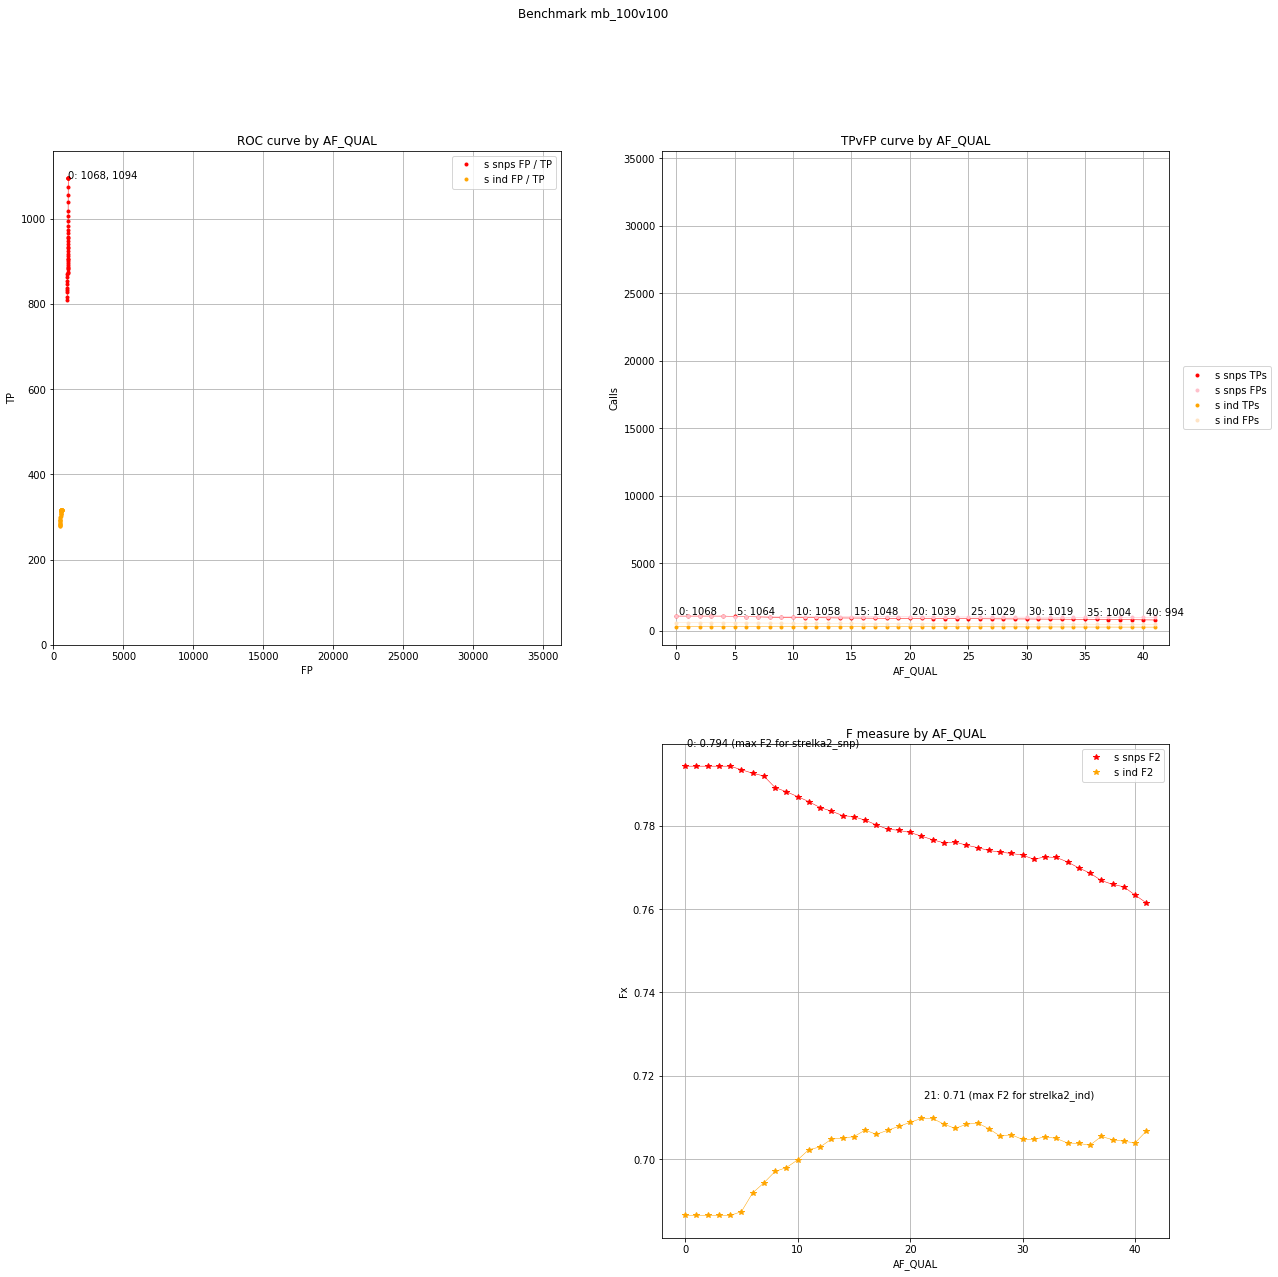

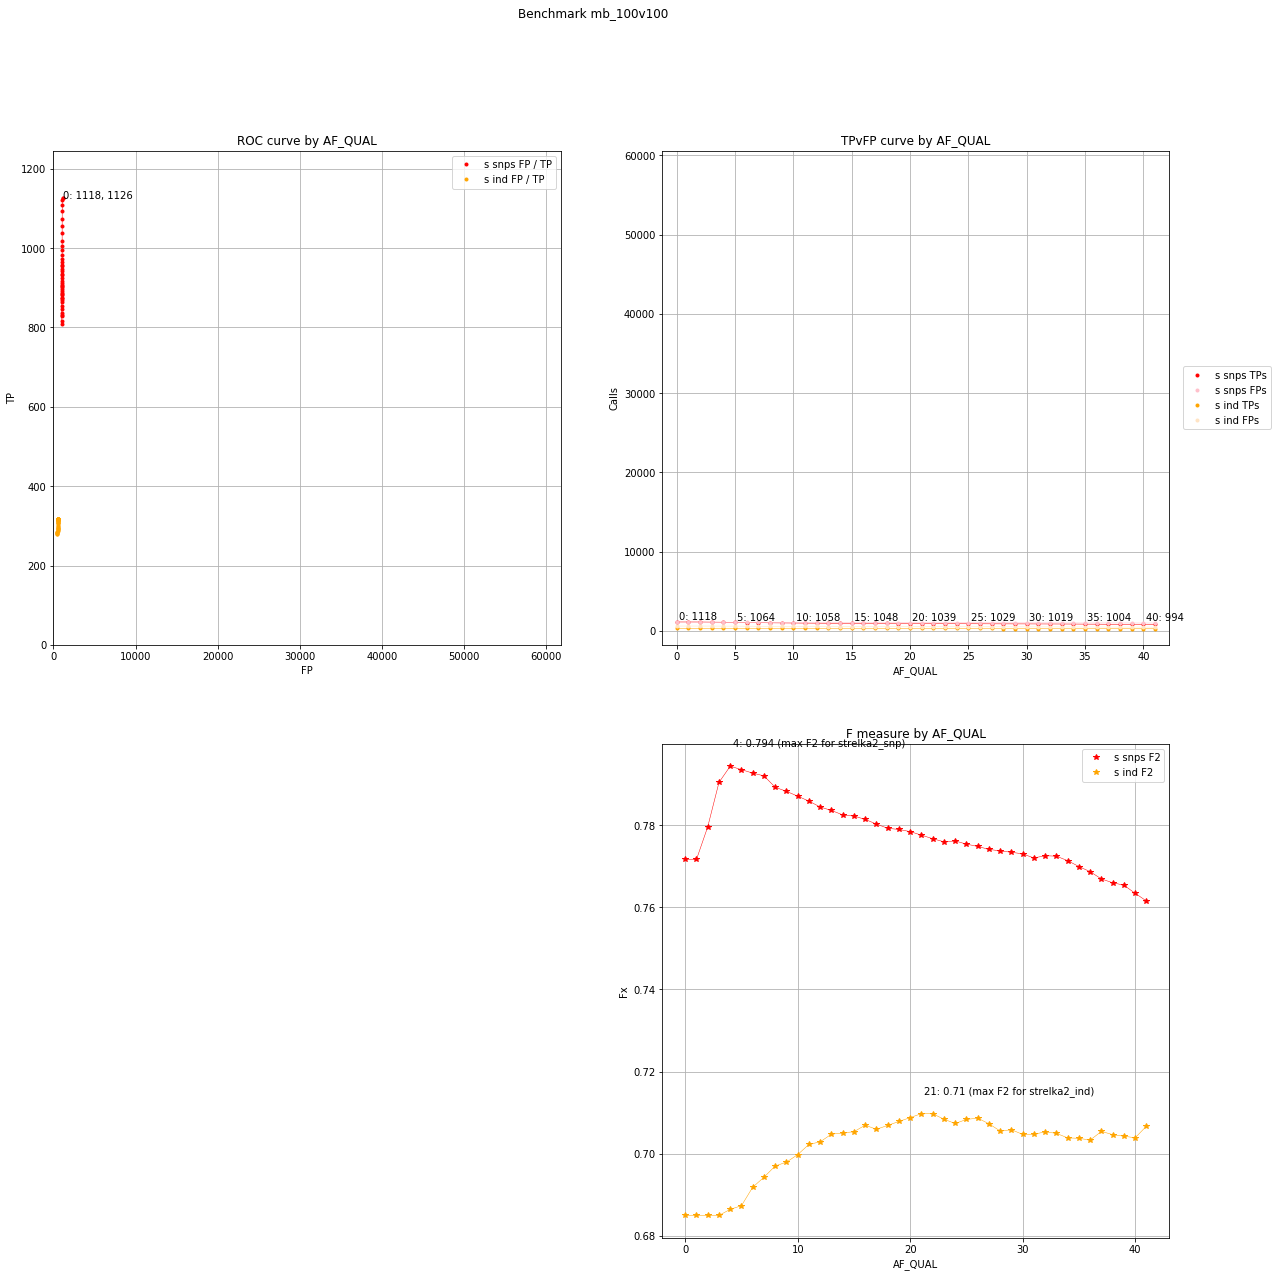

In [583]:
def get_evs(v):
    evs = v['SomaticEVS']
    if np.isnan(evs): evs = 20
    return evs

def get_qual(v):
    """
    called if:
        called with 2 of 3
        vardict 
    if vardict_typ startswith t, change vardict_typ to fn
    """


#    print(v)
#     if v['caller'] == 'strelka2':
#         return get_evs(v)
    if v['vardict_typ'].startswith('t'):
        return v['QUAL']
    else:
        return 41

def get_af_qual(v):
    if v['vardict_typ'] in ('tp', 'fp'):
        return v['QUAL'] * v['TUMOR_AF']
    else:
        return 41

def filt_fn(v):
    return get_af_qual(v) > 0.1 * 40

plot_roc('mb_100v100', 'AF_QUAL', start=0, end=41, step=1, label_step=5, field_fn=get_af_qual, filt_fn=filt_fn, skip_l=True)
plot_roc('mb_100v100', 'AF_QUAL', start=0, end=41, step=1, label_step=5, field_fn=get_af_qual, skip_l=True)
pass

# TODO: why strelka Fmeasure plot is not flat??

Plotting mb


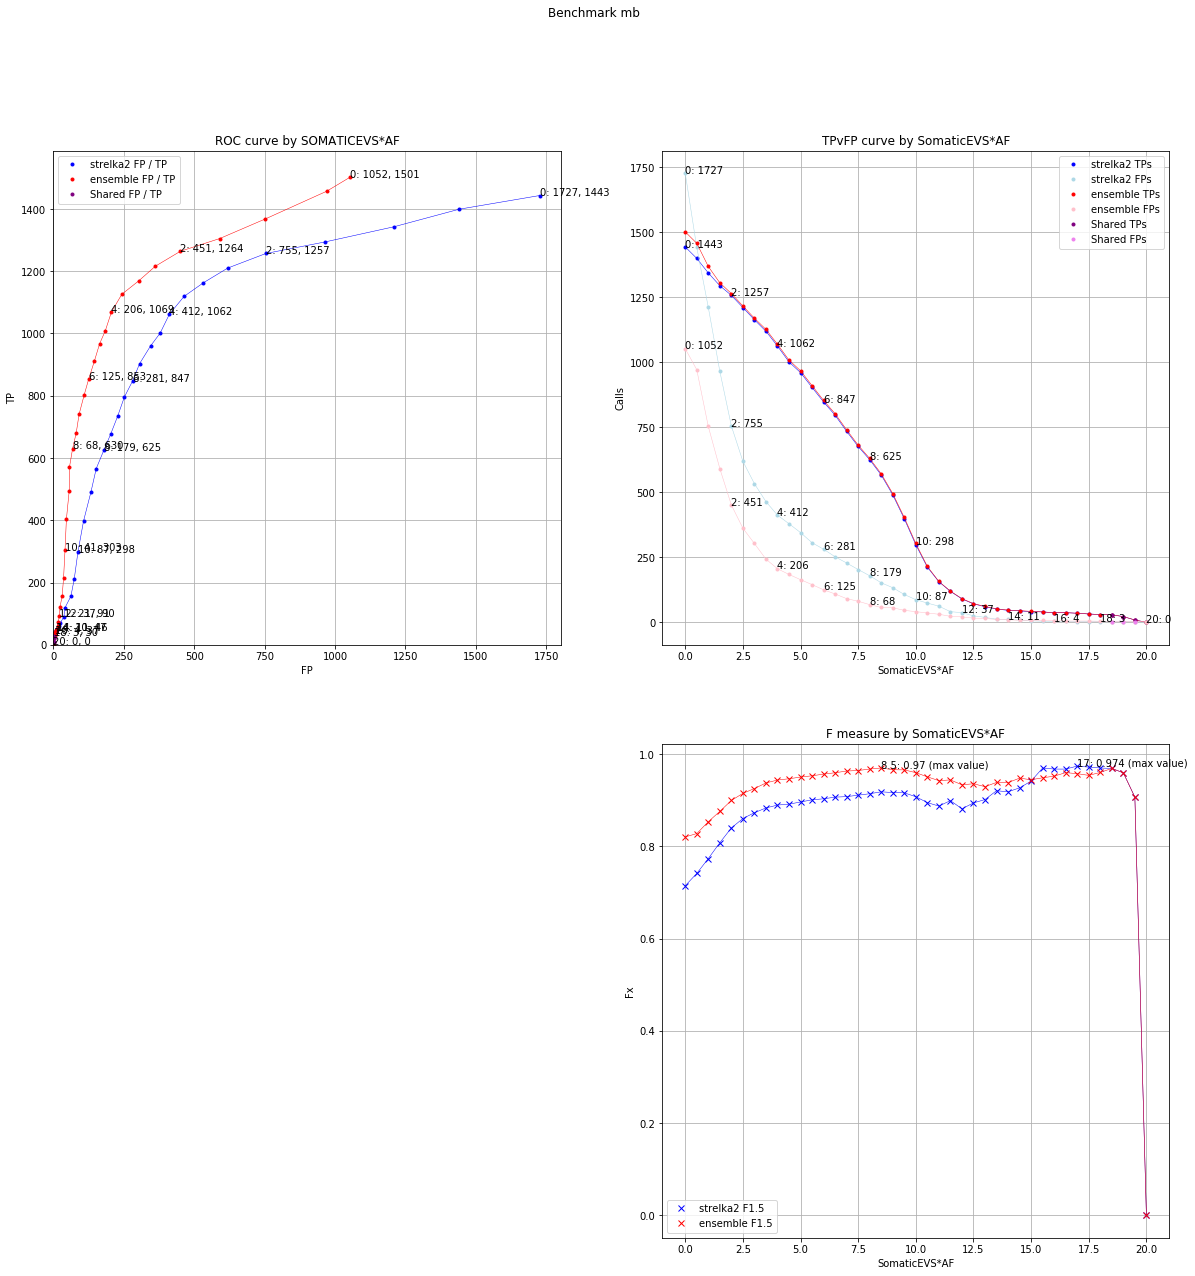

In [257]:
def get_evs_af(v):
    evs = v['SomaticEVS']
    if np.isnan(evs): evs = 20
    #evs = evs/20  # normalise
    taf = v['TUMOR_AF']
    return evs * taf

plot_roc('mb', 'SomaticEVS*AF', start=.0, end=20., step=0.5, label_step=2., field_fn=get_evs_af)
pass

/Users/vsaveliev/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vsaveliev/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Plotting mb_ds


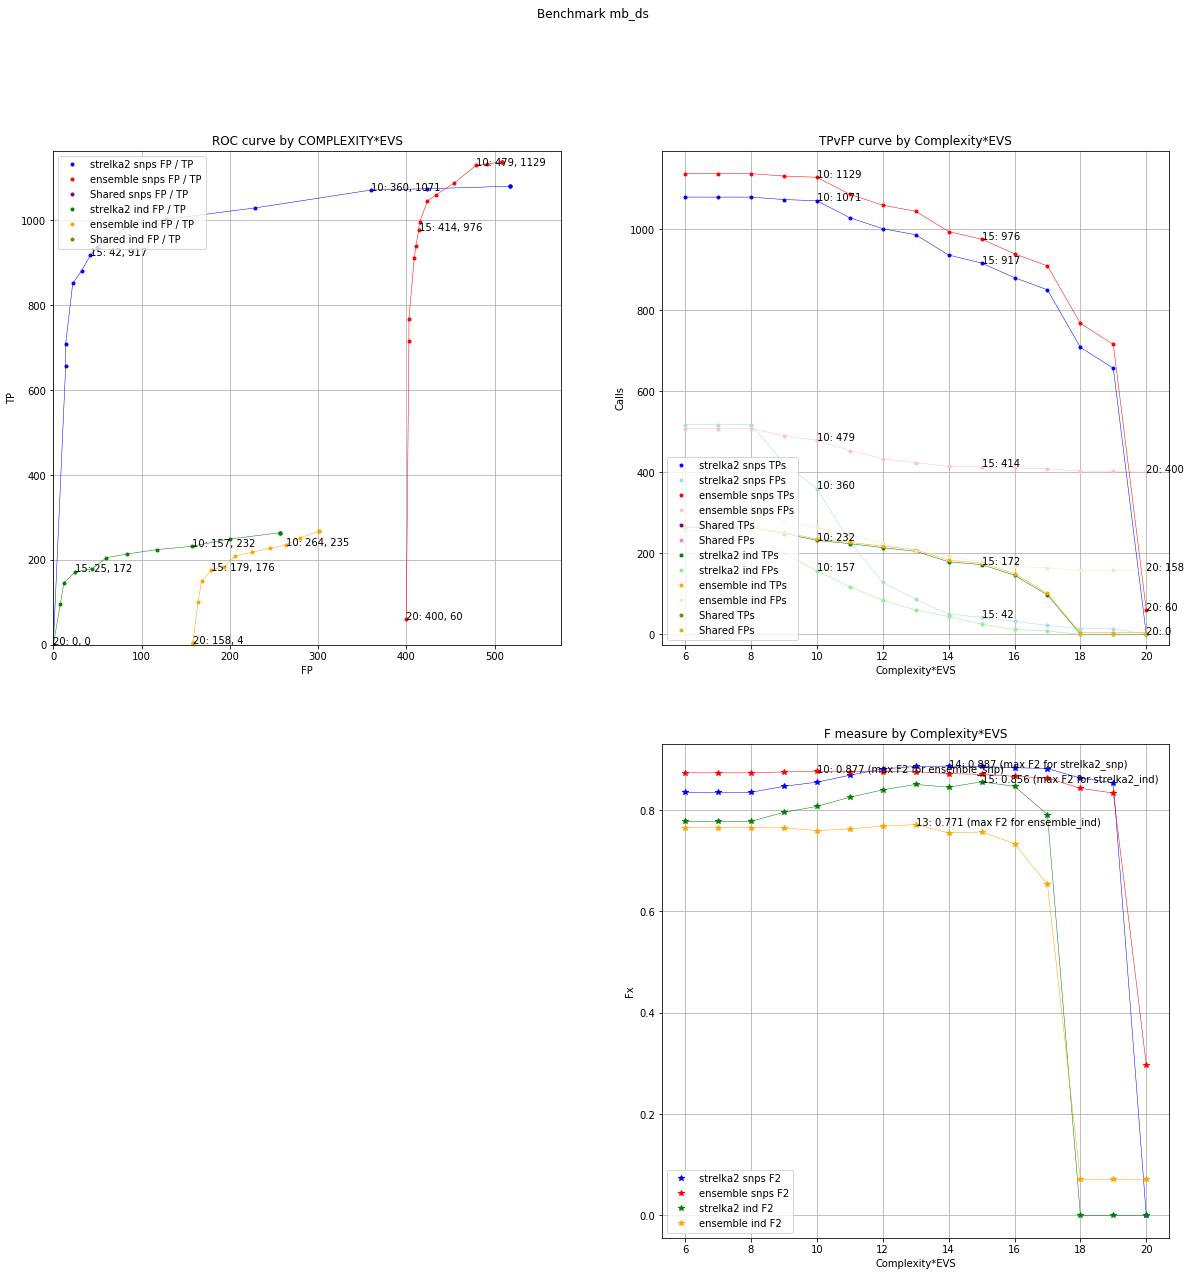

In [397]:
def get_cmpl(v):
    tas = v['tricky_anno']
    cmpl = 2
    if all(ta in ['heng_um75-hs37d5', 'self_chain', 'bad_promoter', 'gc20to25', 'gc25to30', 'gc65to70']
           for ta in tas):
        cmpl = 1
    elif tas:
        cmpl = 0
    return cmpl
   
def filt_fn(v):
    cmpl = get_cmpl(v)
    evs = get_evs(v)
    return cmpl == 2 and evs > 6 or cmpl == 1 and evs > 8 or cmpl == 0 and evs > 10

#plot_roc('mb', 'Complexity', start=0, end=2, step=1, label_step=1, show_values=True, field_fn=get_cmpl)
plot_roc('mb_ds', 'Complexity*EVS', start=6, end=20, step=1, label_step=5, field_fn=get_evs, filt_fn=filt_fn)
pass

/Users/vsaveliev/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vsaveliev/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Plotting mb_ds


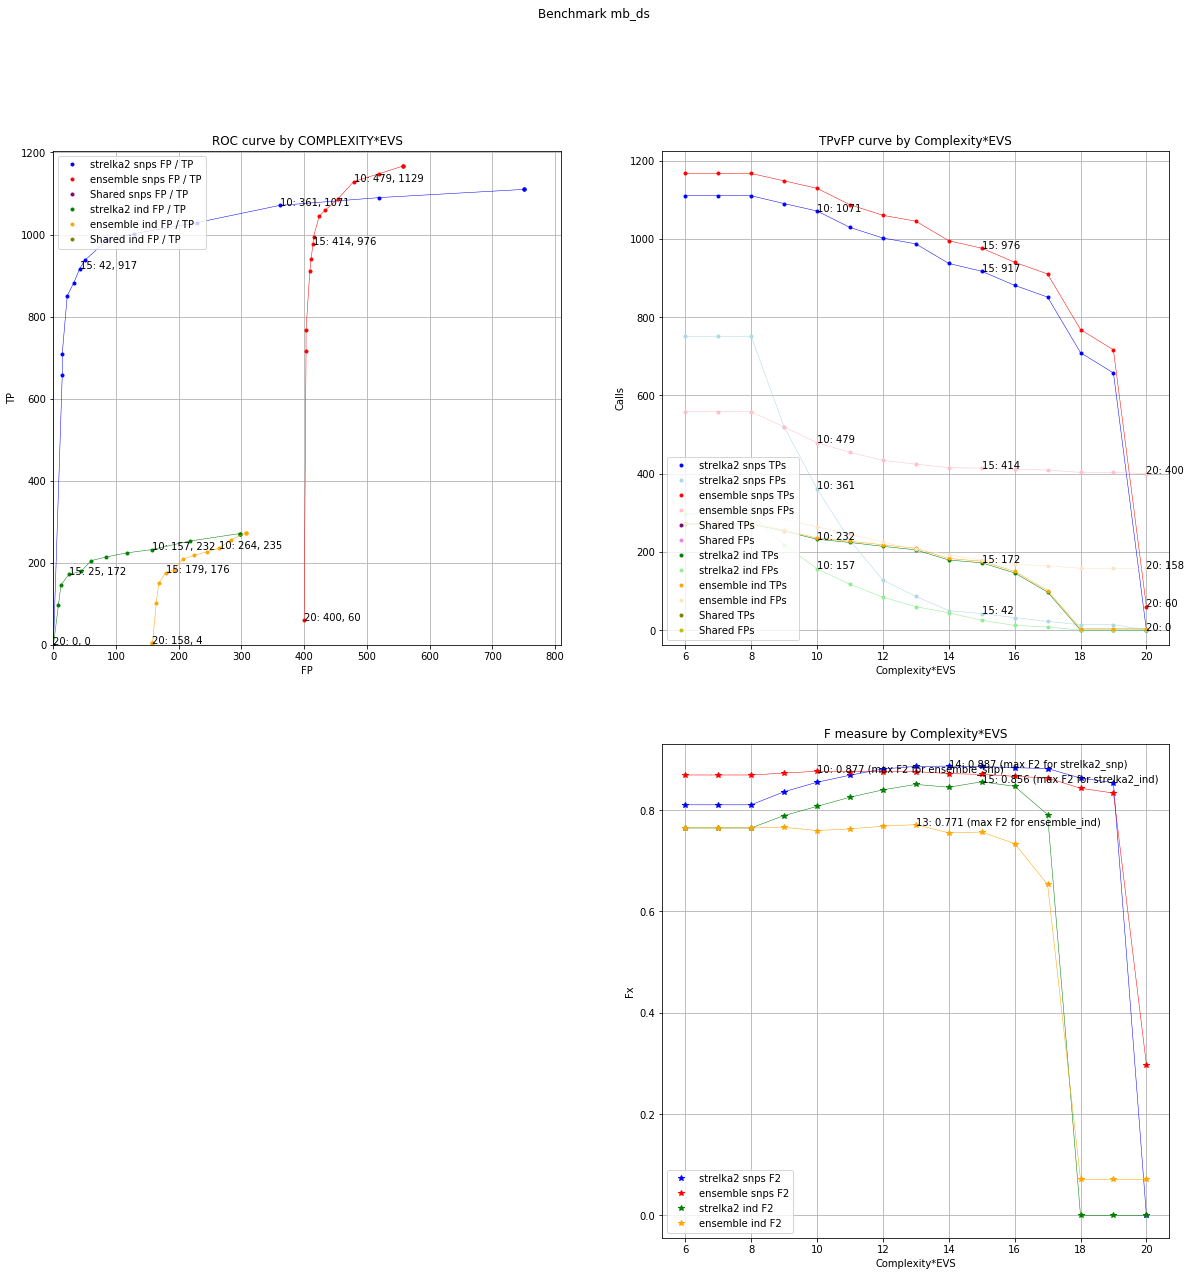

In [398]:
def get_cmpl(v):
    tas = v['tricky_anno']
    cmpl = 2
    if all(ta in ['heng_um75-hs37d5', 'self_chain', 'bad_promoter', 'gc20to25', 'gc25to30', 'gc65to70']
           for ta in tas):
        cmpl = 1
    elif tas:
        cmpl = 0
    return cmpl
   
def filt_fn(v):
    cmpl = get_cmpl(v)
    evs = get_evs(v)
    return  evs > 8

#plot_roc('mb', 'Complexity', start=0, end=2, step=1, label_step=1, show_values=True, field_fn=get_cmpl)
plot_roc('mb_ds', 'Complexity*EVS', start=6, end=20, step=1, label_step=5, field_fn=get_evs, filt_fn=filt_fn)
pass

/Users/vsaveliev/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vsaveliev/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Plotting mb_ds


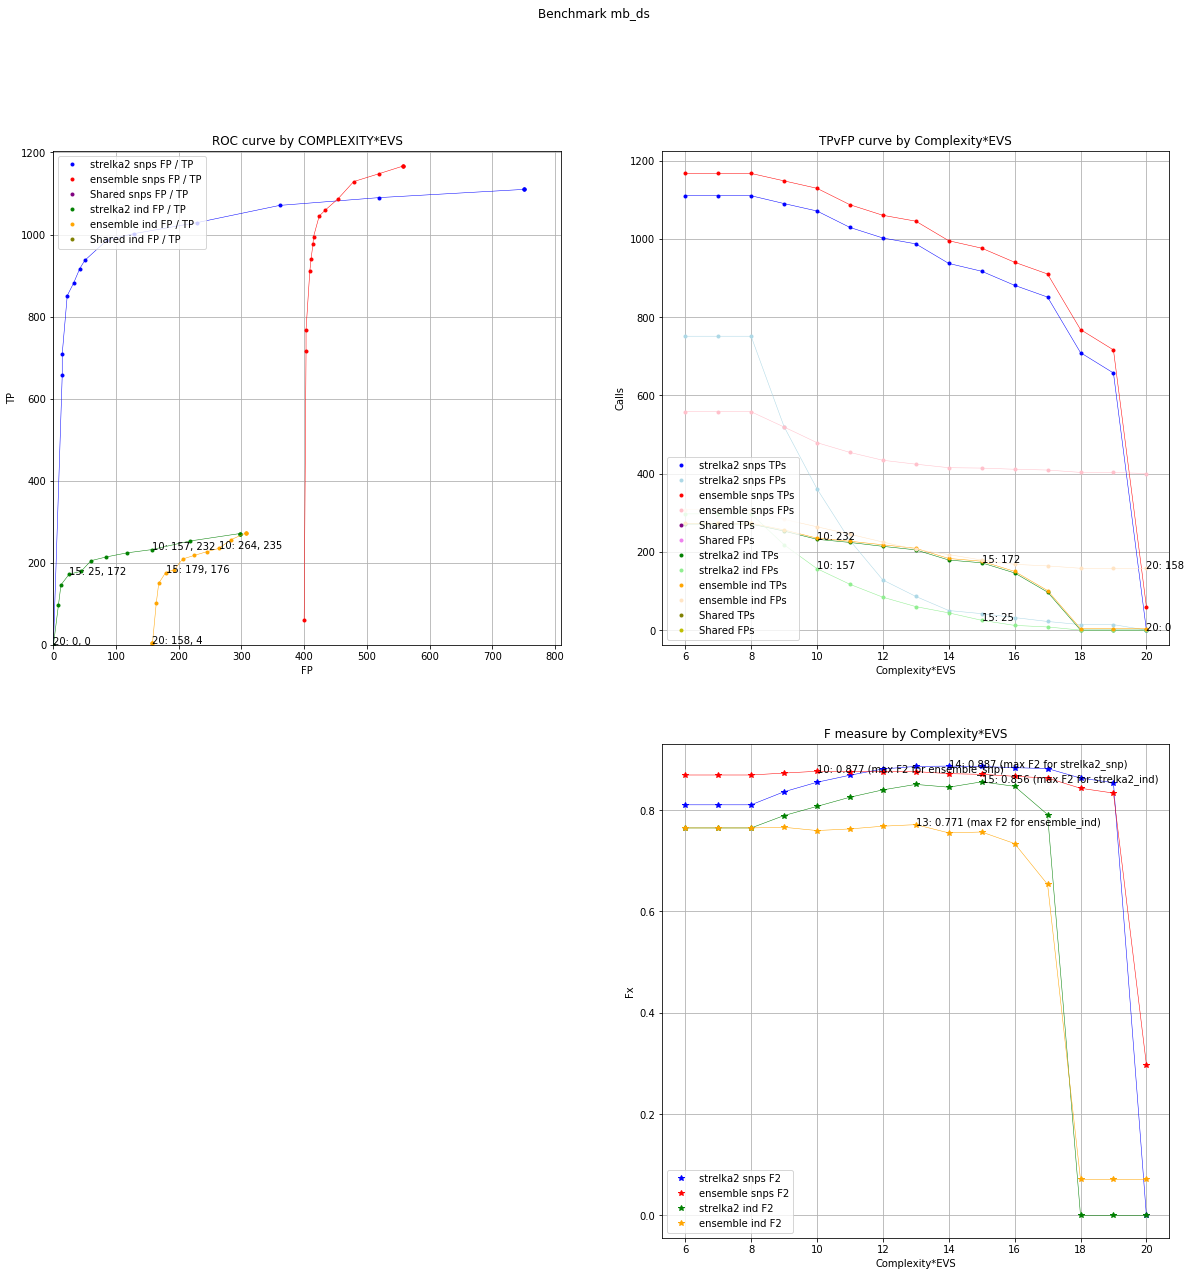

In [391]:
def get_cmpl(v):
    tas = v['tricky_anno']
    cmpl = 2
    if all(ta in ['heng_um75-hs37d5', 'self_chain', 'bad_promoter', 'gc20to25', 'gc25to30', 'gc65to70']
           for ta in tas):
        cmpl = 1
    elif tas:
        cmpl = 0
    return cmpl
   
def filt_fn(v):
    cmpl = get_cmpl(v)
    evs = get_evs(v)
    return  evs > 8

#plot_roc('mb', 'Complexity', start=0, end=2, step=1, label_step=1, show_values=True, field_fn=get_cmpl)
plot_roc('mb_ds', 'Complexity*EVS', start=6, end=20, step=1, label_step=5, field_fn=get_evs, filt_fn=filt_fn)
pass

Plotting mb_100v100


/Users/vsaveliev/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


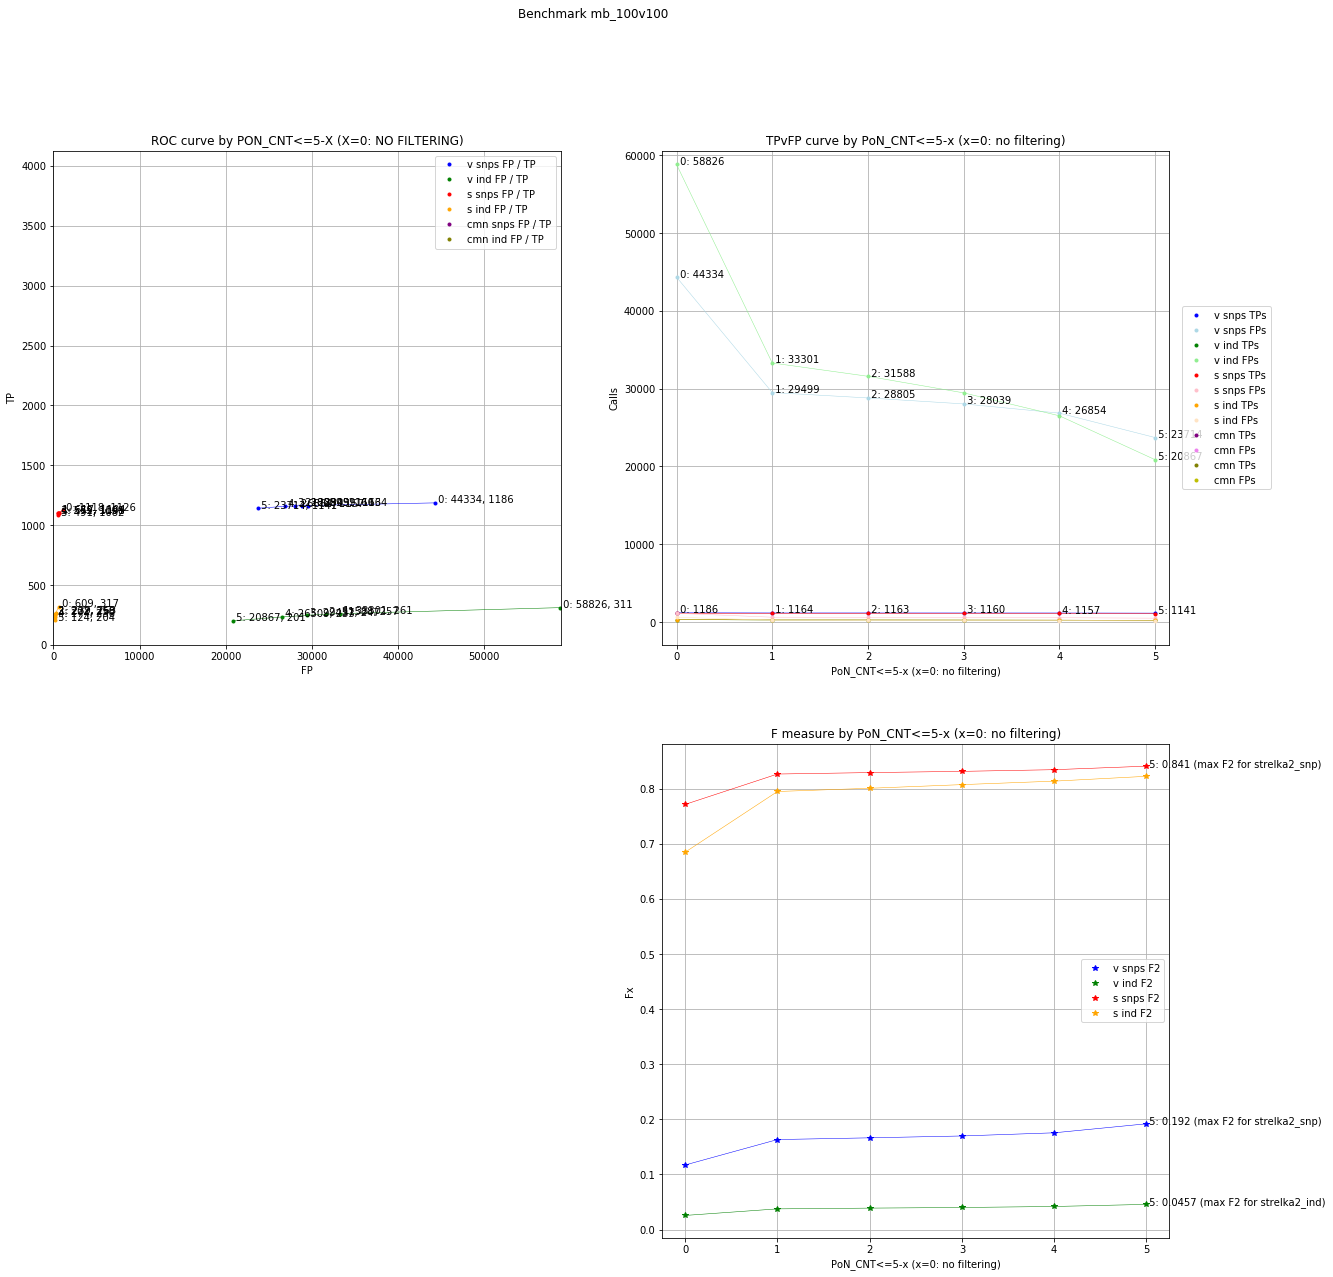

In [555]:
MAX_PON=5
    
def field_fn(v):
    pon_cnt = v['PoN_CNT']
    if np.isnan(pon_cnt): pon_cnt = math.inf

    pon_level = MAX_PON  # we want pon_level be the-more-the-better
    for n in range(MAX_PON):
        if pon_cnt == n:  # PoN_CNT=0 is the best quality, so it translates into the highest value MAX_PON-0
            return MAX_PON-n
    return 0  # if PoN_CNT is as high as MAX_PON, we always return the lowest value 0

#PoN_CNT=0  Pon_CNT<=0  pon_level=5-0 = 5
#PoN_CNT=1  Pon_CNT<=1  pon_level=5-1 = 4
#PoN_CNT=4  Pon_CNT<=4  pon_level=5-4 = 1
#PoN_CNT>=5             pon_level=MAX_PON = 5

plot_roc('mb_100v100', f'PoN_CNT<={MAX_PON}-x (x=0: no filtering)', start=0, end=MAX_PON, step=1, label_step=1, field_fn=field_fn)
pass

Plotting mb_300v50


/Users/vsaveliev/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


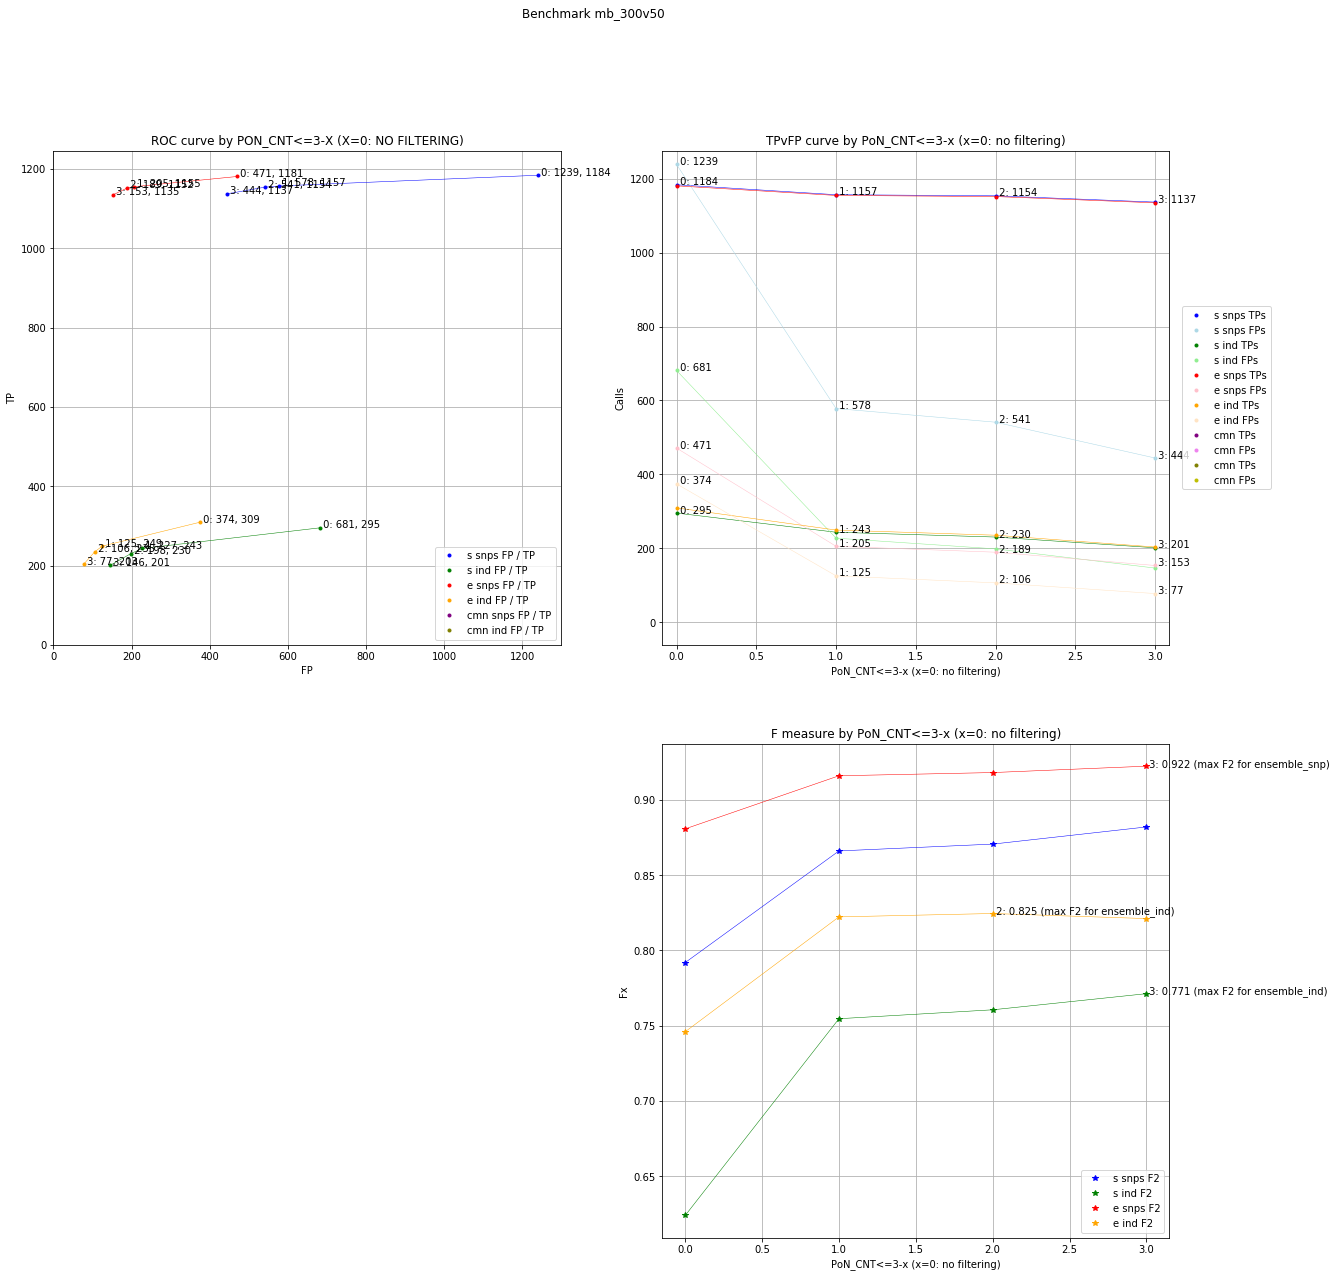

In [511]:
plot_roc('mb_300v50', f'PoN_CNT<={MAX_PON}-x (x=0: no filtering)', start=0, end=MAX_PON, step=1, label_step=1, field_fn=field_fn)
pass

Plotting colo_40pc_ds


/Users/vsaveliev/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


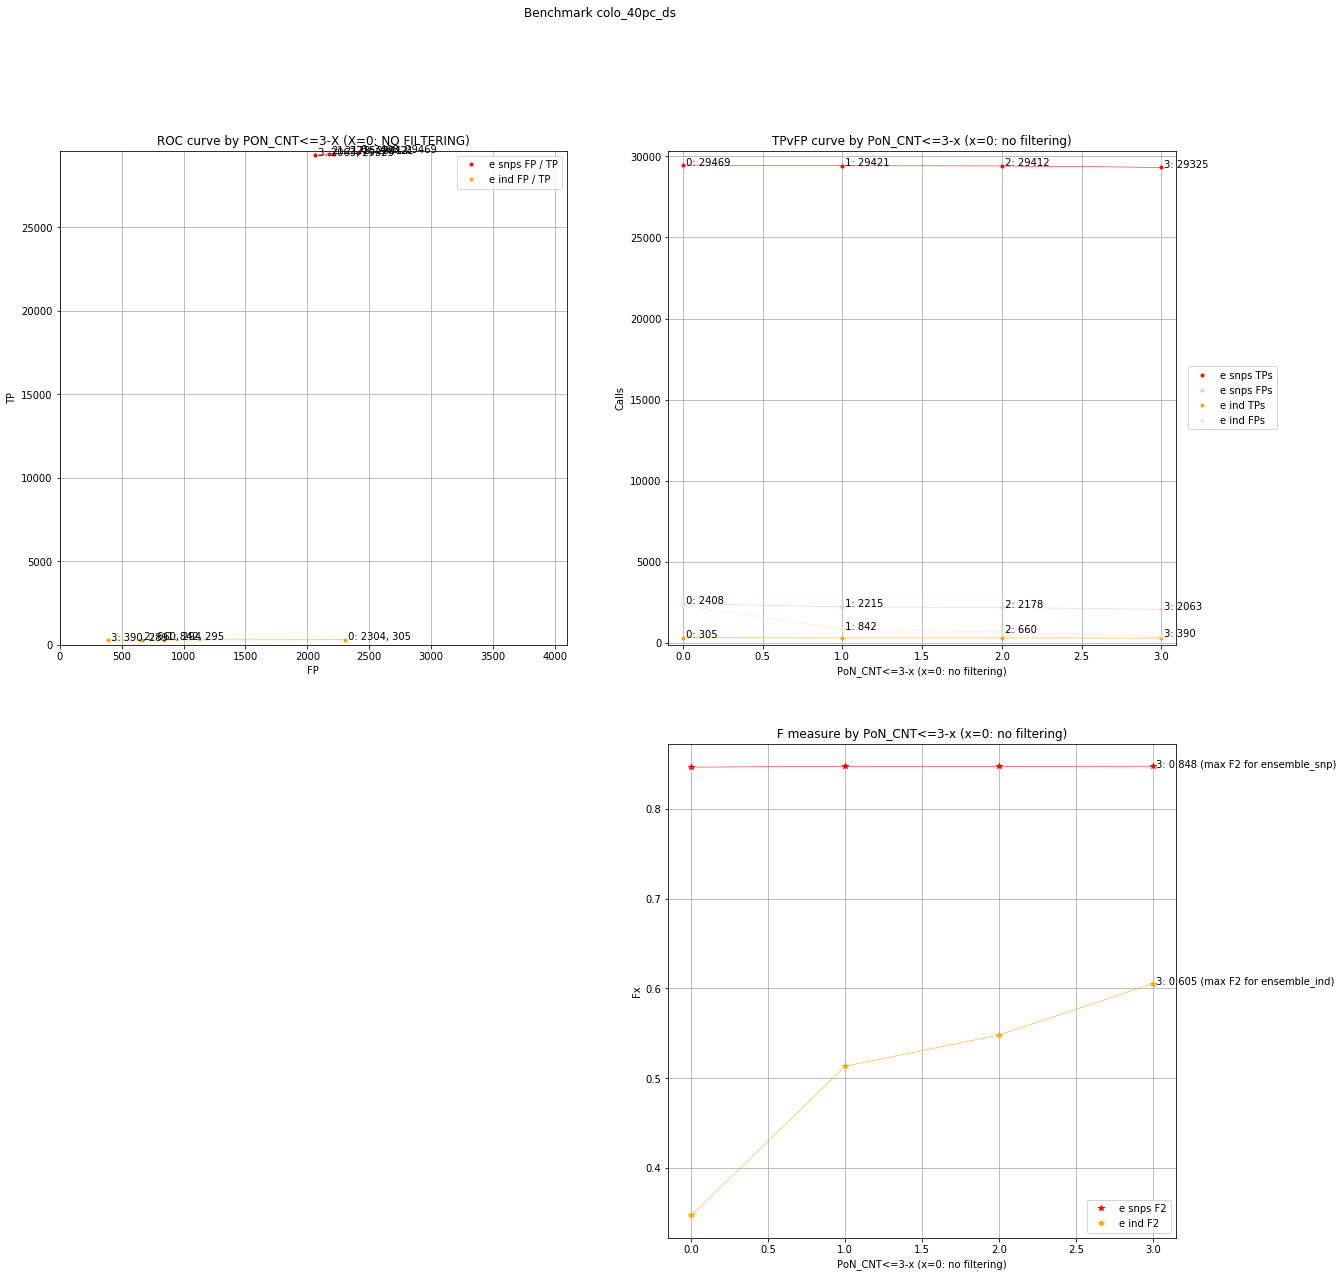

In [514]:
plot_roc('colo_40pc_ds', f'PoN_CNT<={MAX_PON}-x (x=0: no filtering)', start=0, 
    end=MAX_PON, step=1, label_step=1, field_fn=field_fn, skip_l=True)
pass

Plotting colo_40pc_full


/Users/vsaveliev/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


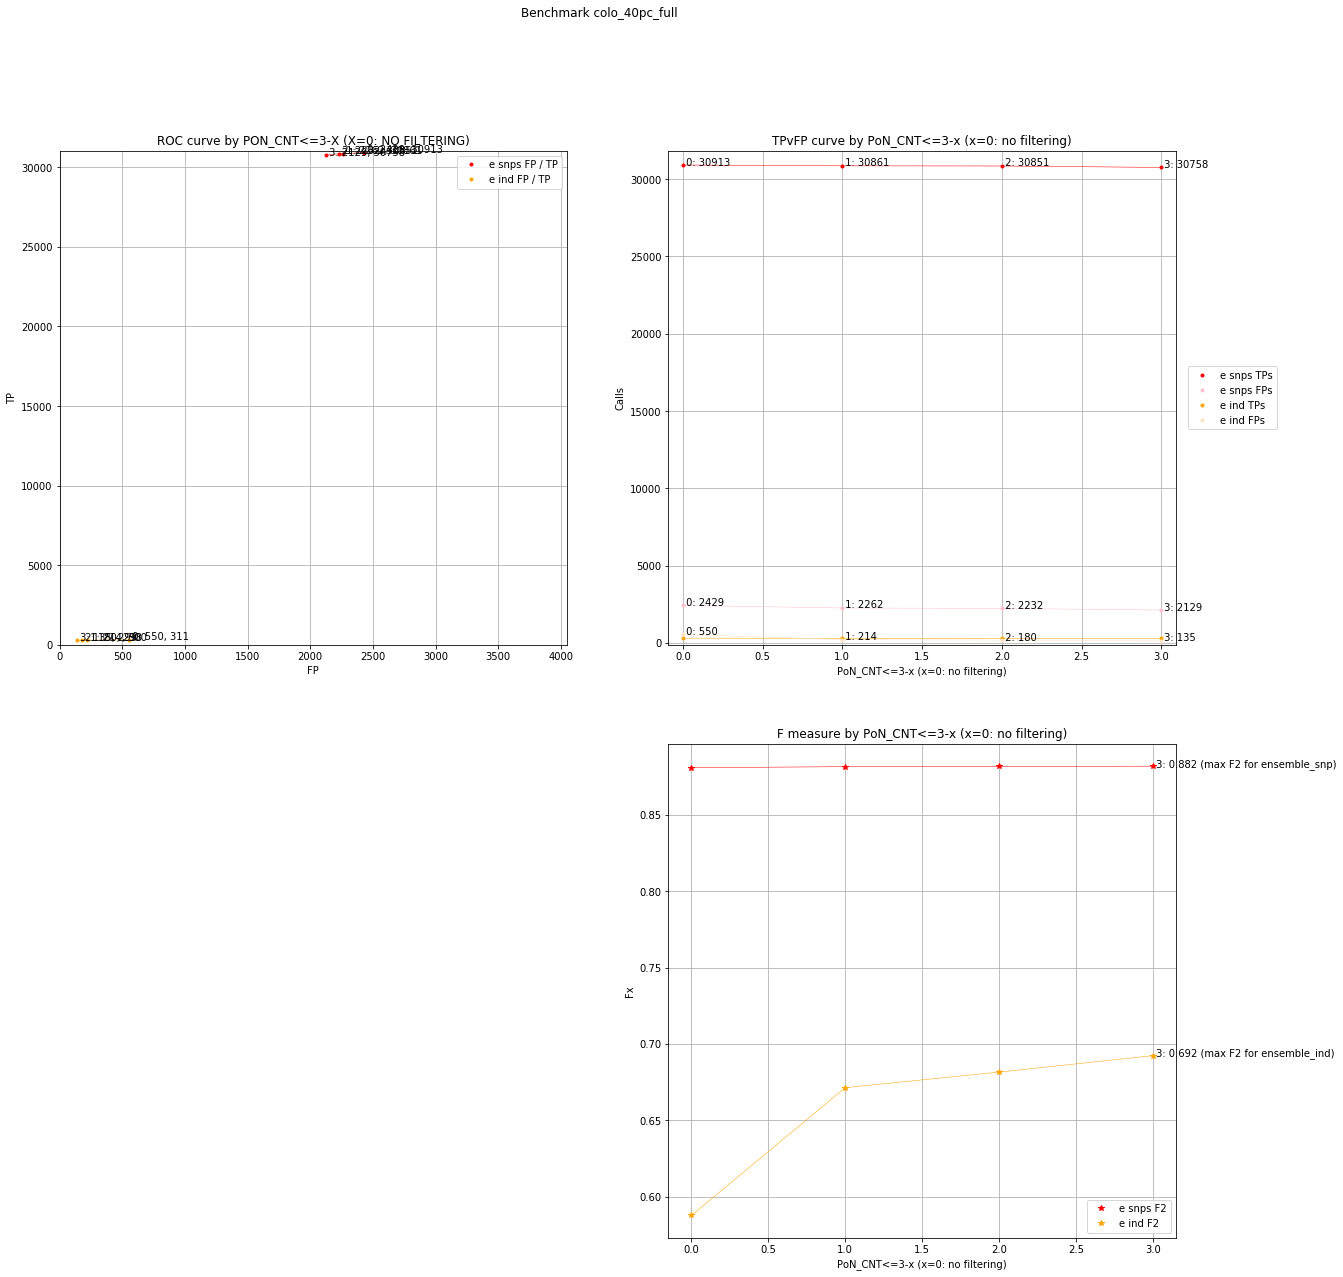

In [515]:
plot_roc('colo_40pc_full', f'PoN_CNT<={MAX_PON}-x (x=0: no filtering)', start=0, end=MAX_PON, step=1, 
    label_step=1, field_fn=field_fn, skip_l=True)
pass

Plotting colo_tgen


/Users/vsaveliev/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


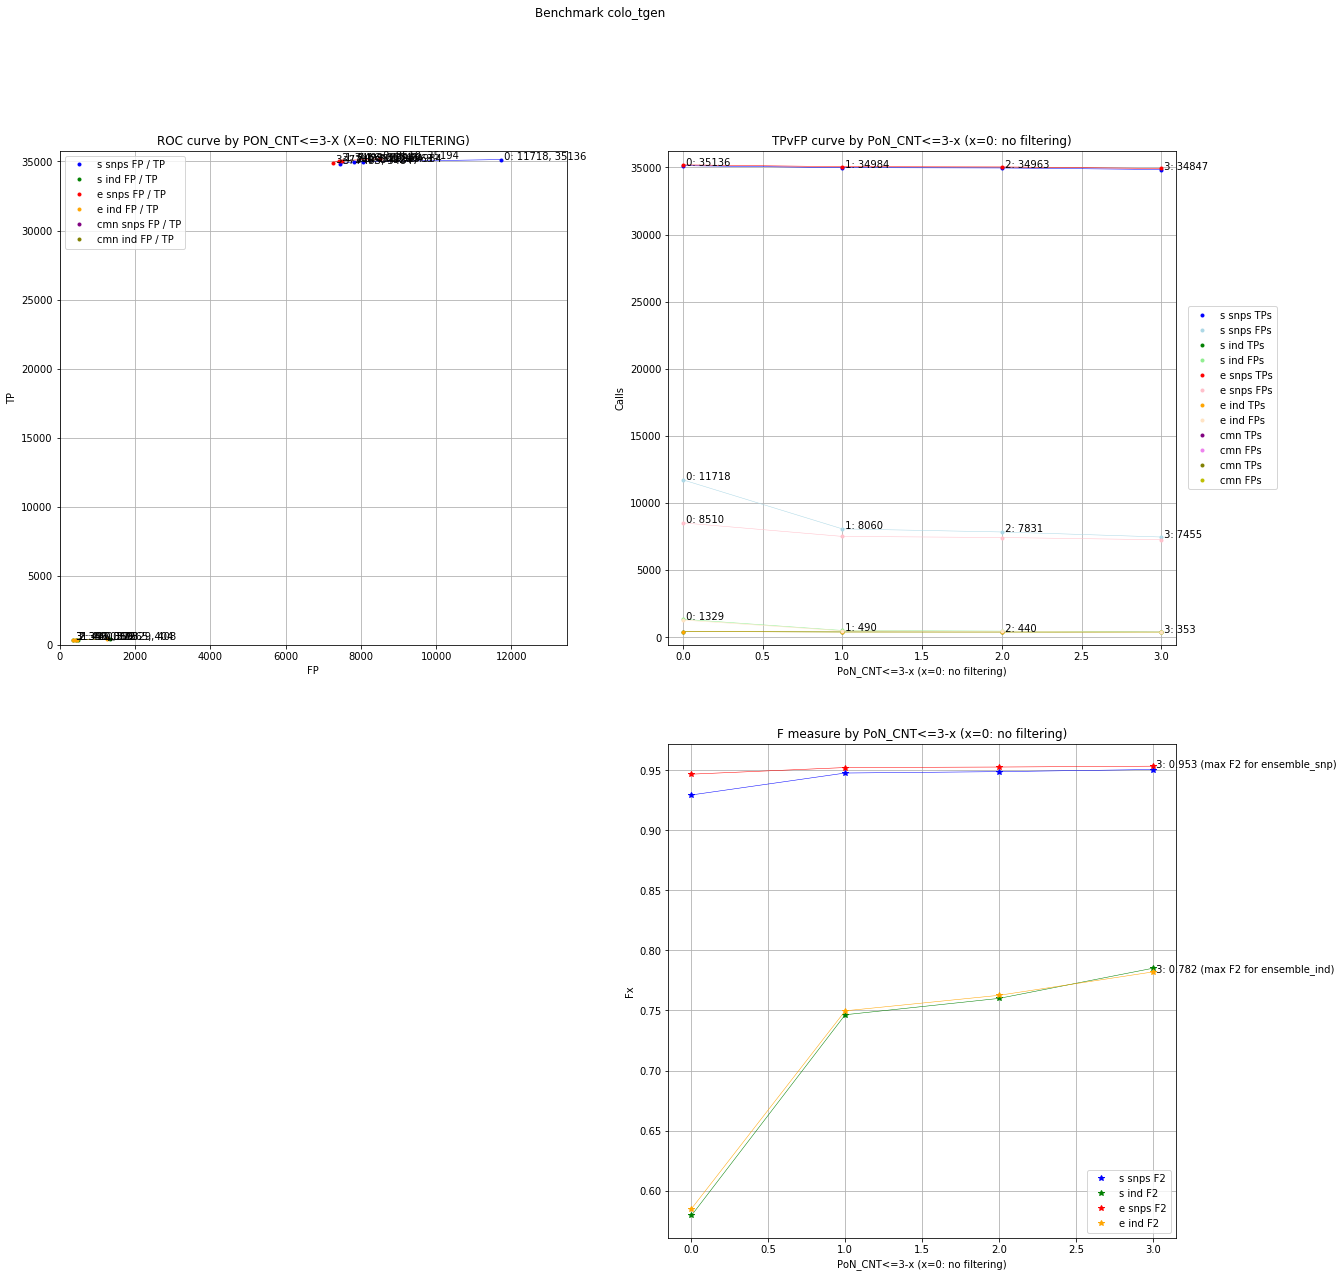

In [495]:
plot_roc('colo_tgen', f'PoN_CNT<={MAX_PON}-x (x=0: no filtering)', start=0, end=MAX_PON, step=1, label_step=1, field_fn=field_fn)
pass

In [4]:
def roc_points(bn, df, f, start=None, end=None, step=None, label_step=None):
    print(f'Calc roc points for {bn} {f}')
    bdf = df.loc[bn]

    start = start or min(bdf[f])
    end = end or max(bdf[f])
    step = step or (0.01 if (end-start)/10<1 else 1)
    label_step = step * 10
    print(f'  calculating for {f} thresholds from {start} to {end} with step of {step}')

    tps, fps, precs, recalls = [], [], [], []

    vals = np.arange(start, end + step, step)
    for val in vals:
        val_df = bdf[bdf[f] >= val]
        tp = len(val_df[val_df['typ'] == 'tp'])
        fn = len(val_df[val_df['typ'] == 'fn'])
        fp = len(val_df[val_df['typ'] == 'fp'])

        tps.append(tp)
        fps.append(fp)
        called = tp + fp
        precs.append(tp / called if called else 0)
        truth = tp + fn
        recalls.append(tp / truth if truth else 0)

#         # Labels
#         for v, tp, fp in zip(vals, tps, fps):
#             label = f'{v}'
#             if v % label_step == 0:  #and k == l and v == lfs[0][0]:
#                 print('Annotating')
#                 roc_ax.annotate(f'{label}: {fp}, {tp}', xy=(fp, tp))
#                 tp_fp_ax.annotate(f'{label}: {tp}', xy=(v, tp))
#                 tp_fp_ax.annotate(f'{label}: {fp}', xy=(v, fp))
#         plt.grid()
    return vals, tps, fps, label_step
    
roc_pts_by_f_by_bn = defaultdict(dict)
for bn in benchmarks_names:
    roc_pts_by_f_by_bn[bn]['TUMOR_AF'] = roc_points(bn, data, 'TUMOR_AF')
    roc_pts_by_f_by_bn[bn]['TUMOR_DP'] = roc_points(bn, data, 'TUMOR_DP', end=500)
    roc_pts_by_f_by_bn[bn]['TUMOR_MQ'] = roc_points(bn, data, 'TUMOR_MQ')

Calc roc points for mb TUMOR_AF
  calculating for TUMOR_AF thresholds from 0.03424660116434097 to 1.0735299587249756 with step of 0.01
Calc roc points for mb TUMOR_DP
  calculating for TUMOR_DP thresholds from 6.0 to 333.0 with step of 1
Calc roc points for mb TUMOR_MQ
  calculating for TUMOR_MQ thresholds from 18.399999618530273 to 60.0 with step of 1
Calc roc points for colo TUMOR_AF
  calculating for TUMOR_AF thresholds from 0.011774499900639057 to 1.0 with step of 0.01
Calc roc points for colo TUMOR_DP
  calculating for TUMOR_DP thresholds from 2.0 to 7409.0 with step of 1
Calc roc points for colo TUMOR_MQ
  calculating for TUMOR_MQ thresholds from 13.75 to 60.0 with step of 1


In [22]:
roc_pts_by_f_by_bn['colo']['TUMOR_AF'][1][50], \
roc_pts_by_f_by_bn['colo']['TUMOR_DP'][1][50], \
roc_pts_by_f_by_bn['colo']['TUMOR_MQ'][1][50]

(19955, 19955, 19955)

In [14]:
# Defining function for plotting ROC and TP/FP ratios curves

from matplotlib import gridspec
from matplotlib.transforms import blended_transform_factory
from ipywidgets import *

tp_colors = ['blue', 'red', 'green']
fp_colors = ['lightblue', 'pink', 'lightgreen']

def plot_roc_2(roc_pts_by_f_by_bn):
    for j, (bn, roc_pts_by_f) in enumerate(roc_pts_by_f_by_bn.items()):
#        print(f'Plotting {bn}')

        fig = plt.figure(figsize=(20, 10*(1+len(roc_pts_by_f))//2))
        grid = gridspec.GridSpec(2, (1+len(roc_pts_by_f))//2)
        plt.suptitle(f'Benchmark {bn}')
        
        roc_ax = plt.subplot(grid[0], label=f'ROC', title=f'ROC curve')
        roc_ax.set_xlabel('TPR')
        roc_ax.set_ylabel('FPR')

        for i, (f, [vals, tps, fps, label_step]) in enumerate(roc_pts_by_f.items()):
 #           print(f'   Plotting {f}')
            # ROC curve plot
            roc_ax.plot(tps, fps, '-', c=tp_colors[i], lw=0.5)
            roc_ax.plot(tps, fps, '.', c=tp_colors[i], label=f'{f}')
            plt.grid()
            
            # TP/FP plot
            tp_fp_ax = plt.subplot(grid[1+i], label=f'TP v FP', title=f'TP v FP curve by {f}')
            tp_fp_ax.set_xlabel(f'{f}')
            tp_fp_ax.set_ylabel('Calls')

            tp_fp_ax.plot(vals, tps, '-', c=tp_colors[i], lw=0.5)
            tp_fp_ax.plot(vals, tps, '.', c=tp_colors[i], label=f'{f} TPs')
            tp_fp_ax.plot(vals, fps, '-', c=fp_colors[i], lw=0.5)
            tp_fp_ax.plot(vals, fps, '.', c=fp_colors[i], label=f'{f} FPs')
            plt.grid()
    
#            max_tp_f = max(tps)
#            max_fp_f = max(fps)

#            delta = (end - start) * 0.05
#            tp_fp_ax.set_xlim([fd['start']-delta, fd['end']+delta])

#            max_y = max(max_tp_f, max_fp_f)
#            delta = max_y*0.05
#            tp_fp_ax.set_ylim([-delta, max_y+delta])
#            print(f'   Setting legend TP-FP {f}')
            tp_fp_ax.legend(*tp_fp_ax.get_legend_handles_labels(), loc=1)
            plt.grid()

            # Labels
#            print(f'   Annotating {f}')
            for v, tp, fp in zip(vals, tps, fps):
                label = f'{v}'
                if v % label_step == 0:  #and k == l and v == lfs[0][0]:
                    roc_ax.annotate(f'{label}: {fp}, {tp}', xy=(tp, fp))
                    tp_fp_ax.annotate(f'{label}: {tp}', xy=(v, tp))
                    tp_fp_ax.annotate(f'{label}: {fp}', xy=(v, fp))
            plt.grid()
        
        # ROC curve limits
 #       max_tp = max(max(vs) for vs in tps_by_f.values())
 #       max_fp = max(max(vs) for vs in fps_by_f.values())

 #       delta = max_tp*0.05
 #       roc_ax.set_xlim([0, max_tp+delta])

 #       delta = max_fp*0.05
 #       roc_ax.set_ylim([0, max_fp+delta])

 #       print(f'   Setting legend ROC')
        roc_ax.legend(*roc_ax.get_legend_handles_labels(), loc=2)
        plt.grid()

def _plot(af, dp, mq):
    min_by_f = {
        'TUMOR_AF': af,
        'TUMOR_DP': dp,
        'TUMOR_MQ': mq,
    }
    r = defaultdict(dict)
    for bn, roc_pts_by_f in roc_pts_by_f_by_bn.items():
        for f, (vals, tps, fps, label_step) in roc_pts_by_f.items():
            triplets = [(v, tp, fp) for (v, tp, fp) in zip(vals, tps, fps) if v >= min_by_f[f]]
            vals, tps, fps = zip(*triplets)
            r[bn][f] = vals, tps, fps, label_step

    plot_roc_2(r)

interact(_plot, af=0.01, dp=10, mq=20)